## 本程序对预测结果以及原值进行比较分析，给出各种图表

## 输入文件有2个，一是预测文件，默认在prediction文件夹内，另一个是原值文件，默认在“datasets”文件夹下；这两个文件都是一列数据，原则上没有格式，但数值个数需要相等。
## 输出文件很多，默认在prediction_analysis文件夹中，包含各种txt、csv和图文件

last update: 2022.6.11

在47_分析_20220611的基础上进行修改，将所有函数、类提前

contacts：zhaohf@ihep.ac.cn

In [ ]:
# Abbreviation used in the code:
# dir   :  directory
# lab   :  label
# pred  :  prediction
# diff  :  difference
# err   :  error
# abs   :  absolute
# ana   :  analysis
# pre   :  prefix
# dict  :  dictionary
# str   :  string

# 配置环境

通用模块构建
  检查python、Tensorflow等模块的版本，确保搭建的框架能够稳定运行。

In [1]:
import os
import sys
assert sys.version_info >= (3, 5)
#
import pandas as pd
import numpy as np
#
import matplotlib as mpl
import matplotlib.pyplot as plt
#
import math

输出导入模板的版本。

In [2]:
print('python version:',sys.version)
print('numpy version:',np.__version__)
print('panda version:',pd.__version__)
print('matplotlib version:',mpl.__version__)
#print('math version:',math.__version__)

python version: 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.21.5
panda version: 1.4.2
matplotlib version: 3.5.1


# 参数设置

## 输入文件设置

In [3]:
#
# 设置需要分析的预测值文件的文件夹名称（及其相对于本代码的路径）以及文件名称
#============================
dir_pred = './../prediction'
#
#file_pred = 'au150_DW_ann_chi_cn1_200_20_1_run_2022_05_28-13_54_31_pred.txt'
#file_pred = 'au150_DW_ann_chi_cr1_200_20_1_run_2022_05_28-15_27_10_pred.txt'
#file_pred = 'au150_DW_ann_k2chi_cn1_200_20_1_run_2022_05_29-23_50_32_pred.txt'
#file_pred = 'au150_DW_ann_k2chi_cr1_200_20_1_run_2022_05_30-06_47_04_pred.txt'
#file_pred = 'au150_DW_ann_xmu_cn1_200_20_1_run_2022_05_28-15_56_55_pred.txt'
file_pred = 'au150_DW_ann_xmu_cr1_200_20_1_run_2022_05_28-16_45_51_pred.txt'
#============================
#
# 设置与预测值相对应的真实值（或理论值）的文件名及所在的文件夹（相对于本代码的路径）
#===============================
dir_label = './../datasets'
#
#file_label = 'Au_cn1_test.txt'
file_label = 'Au_cr1_test.txt'
#===============================
#

## 输出设置

In [4]:
#
# 设置输出结果的文件夹（及其相对于本代码的路径）
#======================================
dir_ana = './../prediction_analysis'
#
# 设置输出文件的文件名前缀，实际文件名将在其后根据内容进行添加
#file_pre = 'au150_DW_ann_chi_cn1_200_20_1_run_2022_05_28-13_54_31'
#file_pre = 'au150_DW_ann_chi_cr1_200_20_1_run_2022_05_28-15_27_10'
#file_pre = 'au150_DW_ann_k2chi_cn1_200_20_1_run_2022_05_29-23_50_32'
#file_pre = 'au150_DW_ann_k2chi_cr1_200_20_1_run_2022_05_30-06_47_04'
#file_pre = 'au150_DW_ann_xmu_cn1_200_20_1_run_2022_05_28-15_56_55'
file_pre = 'au150_DW_ann_xmu_cr1_200_20_1_run_2022_05_28-16_45_51'
#=======================================
#
# 设置feature、label的tag标签，用于后面模型训练、绘图
# feature_index : input feature
# 'chi'   : XAFS chi spectrum
# 'k2chi' : XAFS k^2*chi spectrum
# 'xmu'   : XAFS mu spectrum
#
# label_index: the label to be predicted
# 'CN1' : The coordination number of 1st shell of absorber
# 'CR1' : The average distance of 1st shell to the absorber
#========================
#feature_index = 'chi'
#feature_index = 'k2chi'
feature_index = 'xmu'
#
#label_index = 'CN1'
label_index = 'CR1'
#========================
#

## label、pred值设置

In [6]:
#
# The parameters used in the prediction label stastics and that in the figure plot or formated txt output
# 'dict_label' and 'dict_pred' : the dictionaries including parameter for label and prediction
#                                与label值和预测值有关的参数字典
#
# type : the type of label/prediction
#        label值或预测值的类型
#   'd'  is dispersed
#       离散的，即值是离散分布的，不是连续的，比如配位数（都是整数）
#   'c' is continuous
#       连续的，即值是连续分布的，比如键长
#       注意：由于这里采用的都是回归方法，因此预测值（prediction）类型都是连续的（c）
# step ：interval length for label/prediction statistic
#        在对label值和预测值统计时，设置的间隔，即多大间隔的label值或预测值会统计在一起
#        Note: when type is 'd', the step value in the same dictionary should be set though it won't be used in the code.
#        注意：如果类型是离散的，则‘step’的值程序不会使用，但用户仍然需要对其进行设置，不能删除！！
# step_err : interval length for prediction error statistic
#            用于预测误差分析统计时的间隔设置，一般是0.01（1%），如果预测误差很大，为了绘图方便，可以设置大点，如0.05（5%）等。
#==============================
#dict_label = {'type' : 'd'
#             ,'step' : 0.02
#             }
dict_label = {'type' : 'c'
             ,'step' : 0.02
             }
#dict_pred = {'step' : 0.5
#            ,'step_err' : 0.02
#            }
dict_pred = {'step' : 0.02
            ,'step_err' : 0.01
            }
#===============================
#

# 部分函数模块

## 设置绘图格式和保存图片的模块

  确保绘制的图形美观、能保存下来。

In [7]:
# To plot pretty figures
# %matplotlib具体作用是调用matplotlib.pyplot的绘图函数plot()进行绘图时，
# 或生成一个figure画布时，可以直接在你的python console里面生成图像。
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)   # matplotlib.rc 什么意思没找到
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def save_fig(IMAGES_PATH, fig_id, tight_layout=True, fig_extension="png", resolution=300):
    os.makedirs(IMAGES_PATH, exist_ok=True)
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
#    plt.show()

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## pred的常规统计分析

In [8]:
def pred_ana(pred, label):
    """
    """
#
    global diff, diff_abs, err, err_abs
    global n_lab_self, n_lab_after_dot, n_lab_before_dot
    global n_pred_self, n_pred_after_dot, n_pred_before_dot
    global n_pred_abs_self, n_pred_abs_after_dot, n_pred_abs_before_dot
    global n_diff_self, n_diff_after_dot, n_diff_before_dot
    global n_diff_abs_self, n_diff_abs_after_dot, n_diff_abs_before_dot
    global n_err_self, n_err_after_dot
    global n_err_abs_self, n_err_abs_after_dot
#
    diff = pred - label
    diff_abs = np.abs(diff)
    diff2 = np.square(diff)  # = diff**2
#pred_var_mean = np.mean(diff2, axis=0)
    pred_var = np.mean(diff2)
    pred_std = np.sqrt(pred_var)  # = pred_var_mean**0.5
    err = diff / label
    err_abs = np.abs(err)
#
    n_lab_after_dot = 0
    n_lab_before_dot = 0
    for data in label.flatten():
        a = str(data).split(".")
        n_lab_before_dot = max(n_lab_before_dot, len(a[0]))
        if len(a) == 2:
            n_lab_after_dot = max(n_lab_after_dot, len(a[1]))
    n_lab_self = n_lab_before_dot + 1 + n_lab_after_dot
    if n_lab_after_dot == 0:
        n_lab_self = n_lab_before_dot
#
    n_pred_after_dot = 0
    n_pred_before_dot = 0
    for data in pred.flatten():
        a = str(data).split(".")
        n_pred_before_dot = max(n_pred_before_dot, len(a[0]))
        if len(a) == 2:
            n_pred_after_dot = max(n_pred_after_dot, len(a[1]))
    n_pred_self = n_pred_before_dot + 1 + n_pred_after_dot
    if n_pred_after_dot == 0:
        n_pred_self = n_pred_before_dot
#
    n_diff_after_dot = 0
    n_diff_before_dot = 0
    for data in diff.flatten():
        a = str(data).split(".")
        n_diff_before_dot = max(n_diff_before_dot, len(a[0]))
        if len(a) == 2:
            n_diff_after_dot = max(n_diff_after_dot, len(a[1]))
    n_diff_after_dot = min(max(n_diff_after_dot, n_lab_after_dot), n_pred_after_dot)
    n_diff_self = n_diff_before_dot + 1 + n_diff_after_dot
    if n_diff_after_dot == 0:
        n_diff_self = n_diff_before_dot
#
    n_diff_abs_after_dot = 0
    n_diff_abs_before_dot = 0
    for data in diff_abs.flatten():
        a = str(data).split(".")
        n_diff_abs_before_dot = max(n_diff_abs_before_dot, len(a[0]))
        if len(a) == 2:
            n_diff_abs_after_dot = max(n_diff_abs_after_dot, len(a[1]))
    n_diff_abs_after_dot = min(max(n_diff_abs_after_dot, n_lab_after_dot), n_pred_after_dot)
    n_diff_abs_self = n_diff_abs_before_dot + 1 + n_diff_abs_after_dot
    if n_diff_abs_after_dot == 0:
        n_diff_abs_self = n_diff_abs_before_dot
#
# error and |error| will be formatted as -4.326E-02
    n_err_after_dot = 3
    n_err_self = n_err_after_dot + 4 + 2 + 1
    n_err_abs_after_dot = n_err_after_dot
    n_err_abs_self = n_err_after_dot + 4 + 2
#
#  var
    a = str(pred_var).split(".")
    n_var_before_dot = len(a[0])
    if len(a) == 2:
#        n_var_after_dot = len(a[1])
        n_var_after_dot = min(len(a[1]), n_diff_abs_after_dot)
        n_var = n_var_before_dot + 1 + n_var_after_dot
    else:
        n_var_after_dot = 0
    if n_var_after_dot == 0:
        n_var = n_var_before_dot
#  std
    a = str(pred_std).split(".")
    n_std_before_dot = len(a[0])
    if len(a) == 2:
#        n_std_after_dot = len(a[1])
        n_std_after_dot = min(len(a[1]), n_diff_abs_after_dot)
        n_std = n_std_before_dot + 1 + n_std_after_dot
    else:
        n_std_after_dot = 0
    if n_std_after_dot == 0:
        n_std = n_std_before_dot
#
    n_all = max(n_lab_self, n_pred_self, n_diff_self, n_diff_abs_self, n_err_self, n_err_abs_self, n_var, n_std)
#
    list_dict_predVslabel = [
        {'Pred_Max'          : np.max(pred),        'fmt': f"{n_all}.{n_pred_after_dot}f"},
        {'Pred_Min'          : np.min(pred),        'fmt': f"{n_all}.{n_pred_after_dot}f"},
        {'Pred_mean'         : np.mean(pred),       'fmt': f"{n_all}.{n_pred_after_dot}f"},
        {'Pred_median'       : np.median(pred),     'fmt': f"{n_all}.{n_pred_after_dot}f"},
        {'diff_Max'          : np.max(diff),        'fmt': f"{n_all}.{n_diff_after_dot}f"},
        {'diff_Min'          : np.min(diff),        'fmt': f"{n_all}.{n_diff_after_dot}f"},
        {'diff_mean'         : np.mean(diff),       'fmt': f"{n_all}.{n_diff_after_dot}f"},
        {'diff_median'       : np.median(diff),     'fmt': f"{n_all}.{n_diff_after_dot}f"},
        {'|diff|_Max'        : np.max(diff_abs),    'fmt': f"{n_all}.{n_diff_abs_after_dot}f"},
        {'|diff|_Min'        : np.min(diff_abs),    'fmt': f"{n_all}.{n_diff_abs_after_dot}f"},
        {'|diff|_mean(MAE)'  : np.mean(diff_abs),   'fmt': f"{n_all}.{n_diff_abs_after_dot}f"},
        {'|diff|_median'     : np.median(diff_abs), 'fmt': f"{n_all}.{n_diff_abs_after_dot}f"},
        {'pred_Var(MSE)'     : pred_var,            'fmt': f"{n_all}.{n_std_after_dot}f"},
        {'pred_Std(RMSE)'    : pred_std,            'fmt': f"{n_all}.{n_pred_after_dot}f"},
        {'Error_Max'         : np.max(err),         'fmt': f"{n_all}.{n_err_after_dot}E"},
        {'Error_Min'         : np.min(err),         'fmt': f"{n_all}.{n_err_after_dot}E"},
        {'Error_mean'        : np.mean(err),        'fmt': f"{n_all}.{n_err_after_dot}E"},
        {'Error_median'      : np.median(err),      'fmt': f"{n_all}.{n_err_after_dot}E"},
        {'|Error|_Max'       : np.max(err_abs),     'fmt': f"{n_all}.{n_err_abs_after_dot}f"},
        {'|Error|_Min'       : np.min(err_abs),     'fmt': f"{n_all}.{n_err_abs_after_dot}f"},
        {'|Error|_mean(MAPE)': np.mean(err_abs),    'fmt': f"{n_all}.{n_err_abs_after_dot}f"},
        {'|Error|_median'    : np.median(err_abs),  'fmt': f"{n_all}.{n_err_abs_after_dot}f"}
    ]
    return list_dict_predVslabel

### label的初步分析

In [9]:
def label_ana(label):
    """
    """
    label_mean = np.mean(label)
    label_diff = label - label_mean
    label_diff_abs = np.abs(label_diff)
    label_err = label_diff / label
    label_err_abs = np.abs(label_err)
    list_dict_label_attr = [
        {'Max'            : np.max(label)},
        {'Min'            : np.min(label)},
        {'mean'           : np.mean(label)},
        {'median'         : np.median(label)},
        {'diff_Max'       : np.max(label_diff)},
        {'diff_Min'       : np.min(label_diff)},
        {'diff_mean'      : np.mean(label_diff)},
        {'diff_median'    : np.median(label_diff)},
        {'|diff|_Max'     : np.max(label_diff_abs)},
        {'|diff|_Min'     : np.min(label_diff_abs)},
        {'|diff|_mean'    : np.mean(label_diff_abs)},
        {'|diff|_median'  : np.median(label_diff_abs)},
        {'Var'            : np.var(label)},
        {'Std'            : np.std(label)},
        {'error_Max'      : np.max(label_err)},
        {'error_Min'      : np.min(label_err)},
        {'error_mean'     : np.mean(label_err)},
        {'error_median'   : np.mean(label_err)},
        {'|error|_max'    : np.max(label_err_abs)},
        {'|error|_min'    : np.min(label_err_abs)},
        {'|error|_mean'   : np.mean(label_err_abs)},
        {'|error|_median' : np.median(label_err_abs)}
    ]
    return list_dict_label_attr

## pred与label的初步对比结果输出为csv和txt文件

### 输出为csv文件

In [10]:
def pred_ana2csv(label, pred, diff, diff_abs, err, err_abs, file):
    """
    """
    global label_index
#
    df = pd.DataFrame([label.flatten(),
                       pred.flatten(),   # pred.T[0] also works
                       diff.flatten(),
                       diff_abs.flatten(),
                       err.flatten(),
                       err_abs.flatten()]) 
    df = df.transpose() 
    head = [f'Label',
            f'Prediction',
            f'Diff',
            f'|Diff|',
            f'Error',
            f'|Error|']
    df.to_csv(file, index=False, header=head)

### 输出为txt文件

In [11]:
def pred_ana2txt(label, pred, diff, diff_abs, err, err_abs, file):
    """
    将预测数据存为txt文件
    """
#
    global n_lab_self, n_lab_after_dot, n_lab_before_dot
    global n_pred_self, n_pred_after_dot, n_pred_before_dot
    global n_pred_abs_self, n_pred_abs_after_dot, n_pred_abs_before_dot
    global n_diff_self, n_diff_after_dot, n_diff_before_dot
    global n_diff_abs_self, n_diff_abs_after_dot, n_diff_abs_before_dot
    global n_err_self, n_err_after_dot
    global n_err_abs_self, n_err_abs_after_dot
#
    fout = open(file,'w')
#
# set the ourput of prediction value precision
# the delta digit after dot between  label value and prediciton
# for example ,if label is 1.2, delta =2, then the prediction will be precised to be 1.234
    delta  = 3
#
    str_no = 'No.'
    str_lab = 'Label'
    str_pred = 'Predict'
    str_diff = 'Diff'
    str_diff_abs = '|Diff|'
    str_err = 'Error'
    str_err_abs = '|Error|'
#
# n_xx 是输出格式中各列的占位数
    n_maxnd_label = len(str(label.size))                     # label的个数，如1万，则需要5位数
    n_no = max(n_maxnd_label,len(str_no))
#
    n_lab = max(n_lab_self, len(str_lab))
    n_pred = max(n_pred_self, len(str_pred))
    n_diff = max(n_diff_self, len(str_diff))
    n_diff_abs = max(n_diff_abs_self, len(str_diff_abs))
    n_err = max(n_err_self, len(str_err))
    n_err_abs = max(n_err_abs_self, len(str_err_abs))
#
    print(f"{'*'*5:>5} Label   : {dir_label}/{file_label}")
    print(f"{'*'*5:>5} Label   : {dir_label}/{file_label}", file=fout)
    print(f"Total   : {label.size} data")
    print(f"Total   : {label.size} data", file=fout)
#
    print(f"\n{str_no:>{n_no}} {str_lab:>{n_lab}} {str_pred:>{n_pred}} {str_diff:>{n_diff}} {str_diff_abs:>{n_diff_abs}} {str_err:>{n_err}} {str_err_abs:>{n_err_abs}}")
    print(f"\n{str_no:>{n_no}} {str_lab:>{n_lab}} {str_pred:>{n_pred}} {str_diff:>{n_diff}} {str_diff_abs:>{n_diff_abs}} {str_err:>{n_err}} {str_err_abs:>{n_err_abs}}", file=fout)
    print(f"{'-'*(n_no+1+n_lab+1+n_pred+1+n_diff+1+n_diff_abs+1+n_err+1+n_err_abs)}")
    print(f"{'-'*(n_no+1+n_lab+1+n_pred+1+n_diff+1+n_diff_abs+1+n_err+1+n_err_abs)}", file=fout)
    for i in range(pred.size):
        print(f"{i:>{n_no}d} {label[i][0]:>{n_lab}.{n_lab_after_dot}f} {pred[i][0]:>{n_pred}.{n_pred_after_dot}f} {diff[i][0]:>{n_diff}.{n_diff_after_dot}f} {diff_abs[i][0]:>{n_diff_abs}.{n_diff_abs_after_dot}f} {err[i][0]:>{n_err}.{n_err_after_dot}E} {err_abs[i][0]:>{n_err_abs}.{n_err_after_dot}E}")
        print(f"{i:>{n_no}d} {label[i][0]:>{n_lab}.{n_lab_after_dot}f} {pred[i][0]:>{n_pred}.{n_pred_after_dot}f} {diff[i][0]:>{n_diff}.{n_diff_after_dot}f} {diff_abs[i][0]:>{n_diff_abs}.{n_diff_abs_after_dot}f} {err[i][0]:>{n_err}.{n_err_after_dot}E} {err_abs[i][0]:>{n_err_abs}.{n_err_after_dot}E}", file=fout)
#
    fout.close()

### pred和label简单统计分析输出txt文件

In [12]:
def dict2txt(file, list_dict_predVslabel, list_dict_label_attr):
    """
    将pred对初步统计输出并与label对照
    """
    fout = open(file, 'w')
    str1 = 'Prediction:'
    str2 = 'Label:'
    len_str1 = len(str1)
    len_str2 = len(str2)
    
    print(f"\n{str1}{' '*22}|{' '*3}Label:")
    print(f"\n{str1}{' '*22}|{' '*3}Label:", file=fout)
    for data1, data2 in zip(list_dict_predVslabel, list_dict_label_attr):
        for key in data1.keys():
            if key == 'fmt':
                fmt = data1[key]
            else:
                a = key
        for key in data2.keys():
            b = key
        print(f" {a:<18s} : {data1[a]:>{fmt}} | {data2[b]:>{fmt}} : {b:<20s}")
        print(f" {a:<18s} : {data1[a]:>{fmt}} | {data2[b]:>{fmt}} : {b:<20s}",file=fout)
    fout.close()
#

## 图形展示整体统计误差

### 整体误差

In [13]:
def plot_PredictionError(modify_ylim=False, ylim=[-1,1], ind=0):
    """
    Plot the prediction Error
    if modify_ylim = False, ylim will not be used;
    if modify_ylim = True, ylim set the range of y axis
    ind is the suffix index for the saved photo file 
    """
#
    global file_pre, label_index, path_dir_ana
    global err
#
    file = file_pre + "_prediction_err" + f"_{ind}"
    plt.plot(err, label = f'{label_index}')
    plt.xlabel('Test series')
    plt.ylabel('Error')
    if modify_ylim:
        plt.ylim(ylim)
#    plt.legend(loc='upper left',fontsize=12)
    plt.legend(fontsize=12)
    plt.title(f"{label_index} Prediction Error", fontsize=16)
    save_fig(path_dir_ana, file)

### 整体预测直接比较

In [14]:
def prediction_compare_all(w_plot_label, w_plot_pred, w_plot_diff, ind=0):
    """
    """
#
    global file_pre, label_index
    global label, pred, diff
#
    file = file_pre + f"_prediction_compare_{label_index}_{ind}"
    x = range(pred.size)
    plt.figure(figsize = (20, 16))
    if w_plot_label:
        plt.plot(x, label.flatten()[label.flatten().argsort()], 'o-', color='r', linewidth=0.1, markersize=2, label=f"true_{label_index}")
    if w_plot_pred:
        plt.plot(x, pred.flatten()[label.flatten().argsort()], 'o-', linewidth=0.1, markersize=3, label=f"pred_{label_index}")
    if w_plot_diff:
        plt.plot(x, diff.flatten()[label.flatten().argsort()], 'o-', color='green', linewidth=0.1, markersize=3, label=f"pred_{label_index}_diff")
    plt.xlabel('Test series', fontsize=24)
    if w_plot_label and w_plot_pred:
        plt.ylabel(f'{label_index}', fontsize=24)
#plt.ylabel(f'{label_index}($\AA$)', fontsize=24)
    elif w_plot_diff:
        plt.ylabel(f'{label_index} prediction difference', fontsize=24)
    else:
        pass
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.legend(fontsize=24)
    plt.title(f"{label_index} Regression Performance", fontsize=64)
    save_fig(path_dir_ana, file)
#

### 想画哪个就画哪个

In [15]:
def plot_PredictionCompare3(x_low, x_high, x_ticks=10):
    """
    """
#
    global file_pre, path_dir_ana
    global label_index
    global label, pred
#
    prediction_compare = file_pre + f"_prediction_compare3_{label_index}_{x_low}_{x_high}"
    x = range(pred.size)
    plt.figure(figsize = (10, 8))
    plt.plot(x, label.flatten()[label.flatten().argsort()], 'o-', color='r', linewidth=0.1, markersize=2, label=f"true_{label_index}")
    plt.plot(x, pred.flatten()[label.flatten().argsort()], 'o-', linewidth=0.1, markersize=3, label=f"pred_{label_index}")
    plt.xlabel('Test series')
    plt.ylabel(f'{label_index}')
#    plt.ylabel(f'{label_index}($\AA$)')
    plt.xlim(x_low, x_high)
# The outputs of following two methods are identical
#    ylim_min0 = min(np.min(label.flatten()[label.flatten().argsort()][x_low:x_high]), np.min(pred.flatten()[label.flatten().argsort()][x_low:x_high]))
#    ylim_max0 = max(np.max(label.flatten()[label.flatten().argsort()][x_low:x_high]), np.max(pred.flatten()[label.flatten().argsort()][x_low:x_high]))
    ylim_min0 = min(np.min(label.flatten()[label.flatten().argsort()[x_low:x_high]]), np.min(pred.flatten()[label.flatten().argsort()[x_low:x_high]]))
    ylim_max0 = max(np.max(label.flatten()[label.flatten().argsort()[x_low:x_high]]), np.max(pred.flatten()[label.flatten().argsort()[x_low:x_high]]))
    ylim_len = (ylim_max0 - ylim_min0)*1.1
    ylim_min = (ylim_min0 + ylim_max0)/2 - ylim_len/2
    ylim_max = (ylim_min0 + ylim_max0)/2 + ylim_len/2
    plt.ylim(ylim_min, ylim_max)
    plt.xticks(np.arange(x_low, x_high+1, x_ticks), rotation=0)#rotation控制倾斜角度
#plt.yticks(np.arange(0, np.max(label)+1, 2))
    plt.legend(loc='upper left', fontsize=12)
    plt.title(f"{label_index} Regression Performance", fontsize=16)
    save_fig(path_dir_ana, prediction_compare)

## 分段比较

In [16]:
def plot_PredictionCompare(x_low, x_high, x_ticks=10):
    """
    """
#
    global label_index
    global label, pred
    global path_dir_pre
#
    prediction_compare = f"prediction_compare_{label_index}_{x_low}_{x_high}"
    x = range(pred.size)
    plt.figure(figsize=(8, 8))
    plt.scatter(x, label, marker='o', s=50, label = f'{label_index}')  # s为标记大小
    plt.scatter(x, pred, marker='^', s=50, label = f'{label_index}_pred')
    plt.xlabel('Test series')
    plt.ylabel(f'{label_index}')
#    plt.ylabel(f'{label_index}($\AA$)')
    plt.xlim(x_low, x_high)
    ylim_min0 = min(np.min(label[x_low:x_high]), np.min(pred[x_low:x_high]))
    ylim_max0 = max(np.max(label[x_low:x_high]), np.max(pred[x_low:x_high]))
    ylim_len = (ylim_max0 - ylim_min0)*1.1
    ylim_min = (ylim_min0 + ylim_max0)/2 - ylim_len/2
    ylim_max = (ylim_min0 + ylim_max0)/2 + ylim_len/2
    plt.ylim(ylim_min, ylim_max)
    plt.xticks(np.arange(x_low, x_high+1, x_ticks), rotation=0)#rotation控制倾斜角度
#plt.yticks(np.arange(np.max(label)-1, np.max(label)+1, 2))
#plt.yticks(np.arange(np.around(np.min(label),1)-0.1, np.around(np.max(label),1)+0.1, 0.2))
#    plt.legend(loc='upper right', fontsize=12)
    plt.legend(fontsize=12)
    plt.title(f"{label_index} Regression Performance", fontsize=16)
    save_fig(path_dir_pre, prediction_compare)

In [17]:
def plot_PredictionCompare2(x_low, x_high, x_ticks=10):
    """
    """
#
    global label_index
    global label, pred
    global path_dir_pre
#
    prediction_compare = f"prediction_compare2_{label_index}_{x_low}_{x_high}"
    x = range(pred.size)
    plt.figure(figsize=(10, 8))
    plt.plot(x, label, 'o-', markersize= 8, linewidth=0.7, label = f'{label_index}')
    plt.plot(x, pred, '^-', color='red', markersize=8, linewidth=0.7, label = f'{label_index}_pre')
    plt.xlabel('Test series')
    plt.ylabel(f'{label_index}')
#    plt.ylabel(f'{label_index}($\AA$)')
    plt.xlim(x_low, x_high)
    ylim_min0 = min(np.min(label[x_low:x_high]), np.min(pred[x_low:x_high]))
    ylim_max0 = max(np.max(label[x_low:x_high]), np.max(pred[x_low:x_high]))
    ylim_len = (ylim_max0 - ylim_min0)*1.1
    ylim_min = (ylim_min0 + ylim_max0)/2 - ylim_len/2
    ylim_max = (ylim_min0 + ylim_max0)/2 + ylim_len/2
    plt.ylim(ylim_min, ylim_max)
    plt.xticks(np.arange(x_low,x_high+1, x_ticks), rotation=0)#rotation控制倾斜角度
#    plt.yticks(np.arange(np.around(np.min(label),1)-0.1, np.around(np.max(label),1)+0.1, 0.2))
#    plt.legend(loc='upper right', fontsize=12)
    plt.legend(fontsize=12)
    plt.title(f"{label_index} Regression Performance", fontsize=16)
    save_fig(path_dir_pre, prediction_compare)

## 奇偶图

In [18]:
def plot_parity(file, sts, color, legend, ylabel):
    """
    """
#
    global label_index
    global label
#
    number = sts.size
    #
    plt.figure(figsize=(4,4),dpi=300)
    plt.scatter(label.flatten()[0],
                sts.flatten()[0],
                zorder = -1,
                marker = 'o',
                color = color, 
                alpha = 0.2,
                label = legend)
    #
    for i in range(number)[1:]:
        plt.scatter(label.flatten()[i],
                    sts.flatten()[i],
                    zorder = np.random.uniform(0,1),
                    marker = 'o',
                    color = color, 
    #                alpha = 100/number,
                    alpha = 0.2)
    #
    a = np.min(label)
    b = np.max(label)
    if legend == 'pred':
        plt.plot((a, b), (a, b), color='black',ls='--')
    elif legend == 'diff' or legend == 'err':
        plt.plot((a, b),(0, 0),color='black',ls='--')
    else:
        pass
    plt.legend(fontsize=8)
    plt.title(f"{label_index} Regression Performance", fontsize=12)
    plt.xlabel(f"True {label_index}")
    #plt.xlabel(f"True {label_index}($\AA$)")
    plt.ylabel(ylabel)
    #plt.ylabel(f"Predicted {label_index}($\AA$)")
    #plt.xticks(np.arange(a,b,0.1), rotation=0)#rotation控制倾斜角度
    #plt.yticks(np.arange(a,b,0.1))
    save_fig(path_dir_ana, file)
#

## 各个label详细分析绘图

### 小数位数确定

In [19]:
def digit_dot(step, before_dot = False):
    """
    calculate how many digits after/before dot for the input value.
    """
#
    step_split = str(step).split(".")
    if before_dot:
        digit = len(step_split[0])
    else:
        if len(step_split) == 2:
            digit = len(step_split[1])
        else:
            digit = 0
    return digit

### 列表重排

In [20]:
def duplicate_removal_sort(lis):
    """
    对输入列表去重并排序（升序）
    """
#
    num_list = []
    for i in lis:
        if i not in num_list:
            num_list.append(i)
    num_list.sort(reverse=False)
    return num_list

### 网格区域-->网格点

In [21]:
def locate(data, step, start = False, start0 = 0):
    """
    locate the input data 'data' to the point in the grid with step 'step' if start = True,
    the start point will be start0
    将网格区域-->网格点
    """
#
    trivial = min(0.00001, step/100)
    digit = digit_dot(step)
    if start:
        n = math.floor((data - start0 + trivial) / step)
        data0 = round(n * step + start0, digit)
    else:
        n = math.floor((data + trivial) / step)
        data0 = round(n * step, digit)
#
    return data0

### 列表根据step重排

In [22]:
def list_data(data_list, step, start = False):
    """
    Order the input data(a list) to be a list with the interval 'step' by a ascend order.
    if step == 0, the input data will be consdered as a dipersed list.According to the ordered list,
    creat a dictionary with the key to be the element of list while the value is the corresponding index
    in the list.
    将输入的列表，按照间隔step进行划分，做成一个扣除重复元素的升序列表，值为区间的起始值；如果间隔为0，
    则不做区间划分，直接做成一个离散的列表。然后针对列表，做成一个字典，字典的key是列表的值，字典key对应
    的值是列表中该值对应的序号。
    如果start = True，则间隔从data_list[0]开始，每step一个间隔，若是False，则以step为整数倍的形式呈现。
    For example, if the input list is [1.2, 1.5, 3,0, 6.1, 2.3]，step is 1， then the orderd list is
    [1, 2, 3, 6], the dictionary is {1:1, 2:2, 3:3, 6:4}
    注意，这里不管是离散还是连续值，在进行step区间设置时，都只考虑了有值的空间，没值的区间都跳过。
    """
#
    trivial = 0.00001
    if step >0:
        trivial = min(0.00001, step/100)
#
    list_sort = duplicate_removal_sort(data_list)
#
    digit = digit_dot(step)
#
    if start:
        digit_start = digit_dot(list_sort[0])
    else:
        digit_start = 0
    digit = max(digit, digit_start)
#
    if abs(step) < trivial:
        list_sort0 = list_sort
    elif step > 0:
        list_sort0 = []
        for i, data in enumerate(list_sort):
            data0 = locate(data, step, start=start, start0=list_sort[0])
            if data0 not in list_sort0:
                list_sort0.append(data0)
    else:
        print()
        print(f"** Error!! step {step} is negative!")
        sys.exit()
#
    dict_list_sort = {}
    for i, data in enumerate(list_sort0):
        dict_list_sort[data] = i
#
    return dict_list_sort, list_sort0

### label根据step分析

In [23]:
def label_analysis(label, step_label, dc):
    """
    对label进行分析
    """
#
#    global label, step_label,dc
    global dict_lab, list_lab, dim_label
    global label_min, label_max
    global label_list
    global label_list_avg, label_list_var, label_list_std
#
#  trivial用于避免计算机对边界数据处理不当导致的统计误差。
    trivial = 0.00001
    if step_label > 0:
        trivial = min(trivial, step_label/100)
#
    label_max = np.max(label)
    label_min = np.min(label)
# label值分区
# 将输入的列表，按照间隔step进行划分，做成一个扣除重复元素的升序列表
    dict_lab, list_lab = list_data(list(label.flatten()), step_label)
    dim_label = len(dict_lab)
#
# label_list[i]表示label值落在区间i的样本在label中的值，它是一个列表。
    label_list = []
    for i in range(dim_label):
        label_list.append([])
#
# 得到label从小到大排序的index列表
# label.flatten().argsort() = array([528, 272, ..., 11, 402], dtype=int64)
    for i in label.flatten().argsort():
        if dc == 'd':
            m = dict_lab[label[i][0]]
        elif dc == 'c':
            a = locate(label[i][0], step_label)
            m = dict_lab[a]
        else:
            pass
        label_list[m].append(label[i][0])
#
#
    label_list_avg = [0] * dim_label
    label_list_var = [0] * dim_label
    label_list_std = [0] * dim_label
    for i in range(dim_label):
        label_list_avg[i] = np.mean(label_list[i])
        label_list_var[i] = np.var(label_list[i])
        label_list_std[i] = np.std(label_list[i])
#
    return
#

### 对预测进行分析

In [24]:
def error_distribute(err, step_err):
    """
    对输入数据（error）进行分析
    """
#
    global dc, label, step_label
    global dict_lab, list_lab, dim_label
#
    global N_label
#
#  trivial用于避免计算机对边界数据处理不当导致的统计误差。
    trivial = 0.00001
    if step_err > 0:
        trivial = min(trivial, step_err/100)
#
    err_all_min = np.min(err)
    err_all_max = np.max(err)
#
    dim_err_max = math.floor((err_all_max + trivial) / step_err)
    dim_err_min = math.floor((err_all_min + trivial) / step_err)
    dim_err = dim_err_max - dim_err_min + 1
#
# ERR[i][j]表示label值落在i区间（[(i+dim_label_min)*step_label,(i+1+dim_label_min)*step_label)）、预测error落到[(j+dim_err_min)*step_err,(j+1+dim_err_min)*step_err)中的个数
# ERR_min[i]和ERR_max[i]表示label值落在i区间的样本，其预测error分布区域的最小和最大j值
# err_min[i]和err_max[i]是label值落在区间i，其预测error的最小和最大值。
#
# PRED[i][j] 表示label值落在i区间（[(i+dim_label_min)*step_label,(i+1+dim_label_min)*step_label)），预测落到j区的个数
# PRED_min[i]和PRED_max[i]表示label值落在i区间，其预测分布区域的最小和最大j值
# label_list[i]表示label值落在区间i的样本在label中的值，它是一个列表。
#
    ERR = np.zeros((dim_label, dim_err),dtype=int)
    ERR_max = []
    ERR_min = []
    err_max = []
    err_min = []
    for i in range(dim_label):
        ERR_max.append(0)
        ERR_min.append(dim_err)
        err_max.append(err_all_min)
        err_min.append(err_all_max)
#
# 得到label从小到大排序的index列表
# label.flatten().argsort() = array([528, 272, ..., 11, 402], dtype=int64)
    for i in label.flatten().argsort():
        if dc == 'd':
            m = dict_lab[label[i][0]]
        elif dc == 'c':
            a = locate(label[i][0], step_label)
            m = dict_lab[a]
        else:
            pass
        n = math.floor((err[i][0] + trivial) / step_err) - dim_err_min
        ERR[m][n] += 1
        ERR_max[m] = max(ERR_max[m],n)
        ERR_min[m] = min(ERR_min[m],n)
        err_max[m] = max(err_max[m], err[i][0])
        err_min[m] = min(err_min[m], err[i][0])
#
# axis=0表示列求和，axis=1表示行求
# N_label[i]为label值落在区间i中的样本个数。
# N_err[j] 为err值落在区间j中的样本个数
    N_label = np.sum(ERR, axis=1)
    N_err = np.sum(ERR, axis=0)
    ERR_all_sum = np.sum(N_err)
#
    if ERR_all_sum != label.size:
        print(f"** Error! The number of count is {Err_all_sum}, != {label.size}, the number of label")
#
    return err_min, err_max, ERR, ERR_min, ERR_max, dim_err_min, dim_err, N_err, ERR_all_sum
#

### pred绘图

In [25]:
# 绘制各个cluster的CR统计图
def plot_pred_label(label_type, label_min, label_max, y, xmin, xmax, xminmin, step, path, file, label_index, label_note, w_all=False):
    """
    绘制每个单独label的预测分布
    label_type：label是离散的（d）还是连续的（c）
    label_min, label_max：实际label值在该区间的最小、最大值（真实值，不是标号！）；如果是离散的，则只是用label_min
    y: 列表，其第i个元素为所有样本预测值位于区间[(i+xminmin)*step, (i+1+xminmin)*step)中的个数
    xmin,xmax: 为y列表中非零数的最小和最大区间号。
    xminmin: 如上。
    step: 间隔
    path：图的保存路径
    file：图的名称（不包含后缀）
    label_index：label name
    label_note :用于legend上备注
    w_all: 是否绘制整个而不是单独label，默认是False
    """
#
# 为了绘图中的x轴上显示更为清晰，设置step_plot，让其的整数倍显示数字
    step_plot = 1
# 设置一个很小的数
    trivial = min(0.00001, step/100)
#
    #fig = plt.figure(num=1, figsize=(15, 8),dpi=80) #开启一个窗口，同时设置大小，分辨率
    fig = plt.figure()
    ax1 = fig.add_subplot(1,1,1)
#
    dc = label_type
#
    m = math.floor((label_min+trivial)/step) - xminmin
    if w_all:
        n = math.ceil((label_max-trivial)/step) - xminmin
    else:
        if dc == 'd':
            n = m
        elif dc == 'c':
            n = math.ceil((label_max-trivial)/step) - xminmin
        else:
            pass
    x_min = min(xmin,m)
    x_max = max(xmax,n-1)
    len_x = x_max - x_min + 1
#
    rotation = 0
    ftsz_title = 12
    ftsz_legend = 8
    ftsz_txt = 10
    ftsz_xticklabels = 10
    if len_x >= 13:
        rotation = 30
        ftsz_xticklabels = 8
        if len_x >= 20 :
            ftsz_txt = 8
            ftsz_xticklabels = 6
            if len_x >= 25:
                ftsz_txt = 7
                ftsz_xticklabels = 5
                if len_x >= 40:
                    rotation = 45
                    ftsz_txt = 6
                    ftsz_xticklabels = 4
                    if len_x >= 50:
                        ftsz_txt = 5
                        ftsz_xticklabels = 3
                        if len_x >= 60:
                            ftsz_txt = 4
                            ftsz_xticklabels = 2.5
#
    step_split = str(step).split(".")
    if len(step_split) == 2:
        digit = len(step_split[1])
    else:
        digit = 0
#
    x_index = np.around(np.arange(x_min+xminmin,x_max+1+xminmin)*step, digit)
    y_index = np.array(list(np.zeros(xmin-x_min,dtype=int))+y[xmin:xmax+1]+list(np.zeros(x_max-xmax,dtype=int)))
#
    bar_width = step #定义一个数字代表每个独立柱的宽度
#
    rects1 = ax1.bar(x_index, y_index, width=bar_width,align='edge',alpha=0.5, color='yellow',edgecolor='red',label=label_note)
# 将y_index的值标注在柱状图上，但又不显示为0的数字，因此准备新建一个列表，让其内容与y_index一样，不过0的地方改为无字符''
#
    y_text = []
    for i in list(y_index):
        if i == 0 :
            y_text.append('')
        else:
            y_text.append(i)
#
    for a,b,c in zip(x_index,y_index,y_text):
#        plt.text(a+step/2, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=ftsz_txt)
        plt.text(a+step/2, b+0.05, c, ha='center', va= 'bottom',fontsize=ftsz_txt)
#
#    plt.xticks(x_index + bar_width/2, x_data) #x轴刻度线
    ax1.set_xticks(np.append(x_index,round((x_max+1+xminmin)*step, digit)))
# 设置x轴上的label。原则是0.5的倍数的，都显示；非零的bar的两边，都显示数字。
    x_ticklabels = []
    if dc == 'd':
        for i, a in enumerate(list(x_index)):
            if abs((a/step_plot)-int((a+trivial)/step_plot)) < trivial:
                x_ticklabels.append(a)
            elif y_index[i] != 0:
                x_ticklabels.append(a)
            elif y_index[i]+y_index[i-1] != 0:
                x_ticklabels.append(a)
            else:
                x_ticklabels.append('')
    elif dc == 'c':
        for i, a in enumerate(list(x_index)):
            if abs((a/step_plot)-int((a+trivial)/step_plot)) < trivial:
                x_ticklabels.append(a)
            elif y_index[i] != 0:
                x_ticklabels.append(a)
            elif y_index[i]+y_index[i-1] != 0:
                x_ticklabels.append(a)
            elif round((a+trivial)/step) - round((label_min+trivial)/step) < trivial:
                x_ticklabels.append(a)
            elif round((a+trivial)/step) - round((label_max+trivial)/step) < trivial:
                x_ticklabels.append(a)
            else:
                x_ticklabels.append('')
    else:
        pass
    x_ticklabels.append(round((x_max+1+xminmin)*step, digit))

    ax1.set_xticklabels(np.array(x_ticklabels),rotation=rotation,fontsize=ftsz_xticklabels)
#
#    ax1.set_xlim(min(x0,xmin*step), max(x0,xmax*step))
    ax1.set_ylim(0, max(y)*1.15)
    ax1.set_xlabel(f"Predicted {label_index}")
    ax1.set_ylabel('Number')
    if w_all:
        ax1.set_title(f"Prediction Performance",fontsize=ftsz_title)
    else:
        if dc == 'd':
            ax1.set_title(f"Prediction Performance for {label_index}={label_min}",fontsize=ftsz_title)
            plt.vlines(label_min, 0, max(y), colors="blue", linestyles="dashed", linewidth=2, label = f"{label_index}={label_min}")
        elif dc == 'c':
            ax1.set_title(f"Prediction Performance for {label_index}=[{label_min},{label_max})",fontsize=ftsz_title)
            plt.vlines(label_min, 0, max(y), colors="blue", linestyles="dashed", linewidth=2, label = f"{label_index}=[{label_min},{label_max})")
            plt.vlines(label_max, 0, max(y), colors="blue", linestyles="dashed", linewidth=2)
        else:
            pass
#
#    plt.legend('upper right') #显示图例
    plt.legend(fontsize=ftsz_legend) #显示图例
    plt.tight_layout() #自动控制图像外部边缘，此方法不能够很好的控制图像间的间隔
#
    save_fig(path, file)
    plt.close(fig)
#

### 绘制预测误差

In [26]:
# 绘制各个cluster的CR统计图
def plot_pred_label_err(label_type, label_min, label_max, x0min, x0max, y, xmin, xmax, xminmin, step, path, file, label_index, label_note, tag, w_all=False):
    """
    绘制每个单独label的预测error分布
    label_type：label是离散的（d）还是连续的（c）
    label_min, label_max：实际label值在该区间的最小、最大值（真实值，不是标号！）；如果是离散的，则只是用label_min
    x0min, x0max：error最小最大值；
    y: 列表，其第i个元素为所有样本预测值位于区间[(i+xminmin)*step, (i+1+xminmin)*step)中的个数.
    xmin,xmax: 为y列表中非零数的最小和最大区间号。
    xminmin: 如上。
    step: 间隔
    path：图的保存路径
    file：图的名称（不包含后缀）
    label_index：label name
    label_note :用于legend上备注
    tag：用于竖线说明
    w_all: 是否绘制整个而不是单独label，默认是False
    """
#
# 为了绘图中的x轴上显示更为清晰，设置step_plot，让其的整数倍显示数字
    step_plot = 1
# 设置一个很小的数
    trivial = min(0.00001,step/100)
#
    #fig = plt.figure(num=1, figsize=(15, 8),dpi=80) #开启一个窗口，同时设置大小，分辨率
    fig = plt.figure()
    ax1 = fig.add_subplot(1,1,1)
#
#
    x_min = min(xmin,-xminmin)
    x_max = max(xmax,-xminmin)
    len_x = x_max - x_min + 1
#
    rotation = 0
    ftsz_title = 12
    ftsz_legend = 8
    ftsz_txt = 10
    ftsz_xticklabels = 10
    if len_x >= 13:
        rotation = 30
        ftsz_xticklabels = 8
        if len_x >= 20 :
            ftsz_txt = 8
            ftsz_xticklabels = 6
            if len_x >= 25:
                ftsz_txt = 7
                ftsz_xticklabels = 5
                if len_x >= 40:
                    rotation = 45
                    ftsz_txt = 6
                    ftsz_xticklabels = 4
                    if len_x >= 50:
                        ftsz_txt = 5
                        ftsz_xticklabels = 3
                        if len_x >= 60:
                            ftsz_txt = 4
                            ftsz_xticklabels = 2.5
#
    step_split = str(step).split(".")
    if len(step_split) == 2:
        digit = len(step_split[1])
    else:
        digit = 0
#
    x_index = np.around(np.arange(xmin+xminmin,xmax+1+xminmin)*step, digit)
    y_index = np.array(y[xmin:xmax+1])
#    print(label)
#    print(np.arange(xmin,xmax+1))
#    print(x_index)
#    print(f"y[{xmin} : {xmax+1}] = {y[xmin:xmax+1]}")
#    print(f"y_index = {y_index}")
#
    bar_width = step #定义一个数字代表每个独立柱的宽度
#
    rects1 = ax1.bar(x_index, y_index, width=bar_width,align='edge',alpha=0.5, color='yellow',edgecolor='red',label=label_note)

# 将y_index的值标注在柱状图上，但又不显示为0的数字，因此准备新建一个列表，让其内容与y_index一样，不过0的地方改为无字符''
#
    y_text = []
    for i in list(y_index):
        if i == 0 :
            y_text.append('')
        else:
            y_text.append(i)
#
    for a,b,c in zip(x_index,y_index,y_text):
#        plt.text(a+step/2, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=ftsz_txt)
        plt.text(a+step/2, b+0.05, c, ha='center', va= 'bottom',fontsize=ftsz_txt)
#
#    plt.xticks(x_index + bar_width/2, x_data) #x轴刻度线
#
#    ax1.set_xticks(np.append(x_index,round((xmax+1+xminmin)*step, digit)))
    b = round((xmax+1+xminmin)*step, digit)
    a = np.append(x_index, b)
    c = a
    if x_index[0] > 0:
        c = np.insert(a,0,[0])
    if b < 0:
        c = np.append(a,0)
#    print(f"c={c}")
    ax1.set_xticks(c)
#
# 设置x轴上的label。原则是0.5的倍数的，都显示；非零的bar的两边，都显示数字。
    x_ticklabels = []
    if x_index[0] > 0:
        x_ticklabels.append(round(0,digit))
    for i, a in enumerate(list(x_index)):
        if abs((a/step_plot)-int((a+trivial)/step_plot)) < trivial:
            x_ticklabels.append(a)
        elif y_index[i] != 0:
            x_ticklabels.append(a)
        elif y_index[i]+y_index[i-1] != 0:
            x_ticklabels.append(a)
        else:
            x_ticklabels.append('')
    x_ticklabels.append(b)
    if b < 0:
        x_ticklabels.append(round(0,digit))
#
    ax1.set_xticklabels(np.array(x_ticklabels),rotation=rotation,fontsize=ftsz_xticklabels)
#
#    ax1.set_xlim(min(x0,xmin*step), max(x0,xmax*step))
    ax1.set_ylim(0, max(y)*1.15)
    ax1.set_xlabel(f"Predicted {label_index} {tag}")
    ax1.set_ylabel('Number')
    if w_all:
        ax1.set_title(f"Prediction Performance",fontsize=ftsz_title)
    else:
        if label_type == 'd':
            ax1.set_title(f"Prediction Performance for {label_index}={label_min}",fontsize=ftsz_title)
        elif label_type == 'c':
            ax1.set_title(f"Prediction Performance for {label_index}=[{label_min},{label_max})" ,fontsize=ftsz_title)
        else:
            pass
#
    plt.vlines(x0min, 0, max(y), colors="green", linestyles="dashed", linewidth=1.5, label = f"{tag}_Min")
    plt.vlines(x0max, 0, max(y), colors="blue", linestyles="dashed", linewidth=1.5, label = f"{tag}_Max")
    plt.vlines(0, 0, max(y), colors="black", linestyles="dashed", linewidth=3, label = f"{tag}=0")
#
#    plt.legend('upper right') #显示图例
    plt.legend(fontsize=ftsz_legend) #显示图例
    plt.tight_layout() #自动控制图像外部边缘，此方法不能够很好的控制图像间的间隔
#
    save_fig(path, file)
    plt.close(fig)
#

### 预测绘图总

In [27]:
def plot_err(step_err, tag, err_min, err_max, ERR, ERR_min, ERR_max, dim_err_min, iserr=True):
    """
    绘制每个label的error分布图
    """
#
    global dim_label, list_lab, step_label, digit_step_label, feature_index, label_index
    global dc, path_dir_pre
#
    for i in range(dim_label):
        label_value = list_lab[i]
        label_int_min = list_lab[i]
        label_int_max = round(list_lab[i] + step_label, ndigits= digit_step_label)
        file = f"{feature_index}_{label_index}_{tag.lower()}_{label_value}_step={step_err}"
        label_note = f"{feature_index}/{label_index}"
        if iserr:
            plot_pred_label_err(dc, label_int_min, label_int_max, err_min[i], err_max[i], list(ERR[i]), ERR_min[i], ERR_max[i], dim_err_min, step_err, path_dir_pre, file, label_index, label_note, tag)
        else:
            plot_pred_label(dc, label_int_min, label_int_max, list(ERR[i]), ERR_min[i], ERR_max[i], dim_err_min, step_err, path_dir_pre, file, label_index, label_note)
#

### 误差分布写入txt文件

In [28]:
def err_dist2txt(file, err_note, N_err, dim_err_min, dim_err, step_err, digit_step_err, ERR_min, ERR_max, ERR, ERR_all_sum, n_err_int):
    """
    将统计结果输出到txt
    """
#
#    global dir_model, file_saved_model, dir_feature, file_feature_test, dir_label, file_label, dir_pred, file_pred
    global dir_label, file_label, dir_pred, file_pred
    global dc
    global str_lab, n_lab, n_lab_after_dot, n_lab_int
    global dim_label, list_lab
    global step_label, digit_step_label, label_int_min, label_int_max
#
    fout = open(file,'w')
#
#***** Model   : ./../nn_train/au150_DW_ann_chi_cr1_200_20_1_run_2022_05_28-15_27_10.h5
#***** Fearute : ./../datasets/Au_chi_test.txt
#***** Label   : ./../datasets/Au_cr1_test.txt
#Total   : 595 data
#
#    print(f"{'*'*5} Model      : {dir_model}/{file_saved_model}")
#    print(f"{'*'*5} Fearute    : {dir_feature}/{file_feature_test}")
    print(f"{'*'*5} Label      : {dir_label}/{file_label}")
    print(f"{'*'*5} Prediction : {dir_pred}/{file_pred}")
#    print(f"{'*'*5} Model      : {dir_model}/{file_saved_model}", file=fout)
#    print(f"{'*'*5} Fearute    : {dir_feature}/{file_feature_test}", file=fout)
    print(f"{'*'*5} Label      : {dir_label}/{file_label}", file=fout)
    print(f"{'*'*5} Prediction : {dir_pred}/{file_pred}", file=fout)
    print(f"Total   : {ERR_all_sum} data")
    print(f"Total   : {ERR_all_sum} data", file=fout)
#
#CN1 Predict Distribution:
#
    print(f"\n\n{label_index} {err_note}:")
    print(f"\n\n{label_index} {err_note}:", file=fout)
#
    if dc == 'd':
        print(f"{str_lab:>{n_lab}}", end='')
        print(f"{str_lab:>{n_lab}}", end='', file=fout)
    elif dc == 'c':
        print(f"{str_lab:>{n_lab_int*2+3}}", end='')
        print(f"{str_lab:>{n_lab_int*2+3}}", end='', file=fout)
    else:
        pass
#
    for i in range(dim_err):
        if N_err[i] != 0:
            a = round((i+dim_err_min)*step_err, ndigits=digit_step_err)
            b = round((i+dim_err_min+1)*step_err, ndigits=digit_step_err)
            print(f" [{a:>{n_err_int}.{digit_step_err}f},{b:>{n_err_int}.{digit_step_err}f})", end = '')
            print(f" [{a:>{n_err_int}.{digit_step_err}f},{b:>{n_err_int}.{digit_step_err}f})", end = '', file=fout)
    print()
    print(file=fout)
#
    if dc == 'd':
        print(f"{'-'*(n_lab)}", end='')
        print(f"{'-'*(n_lab)}", end='', file=fout)
    elif dc == 'c':
        print(f"{'-'*(n_lab_int*2+3)}", end='')
        print(f"{'-'*(n_lab_int*2+3)}", end='', file=fout)
    else:
        pass
#
    for i in range(dim_err):
        if  N_err[i] != 0:
            print(f"-{'-'*(n_err_int*2+3)}", end = '')
            print(f"-{'-'*(n_err_int*2+3)}", end = '', file=fout)
    print()
    print(file=fout)
#
    for i in range(dim_label):
        if dc == 'd':
            label_value = list_lab[i]
            print(f"{label_value:>{n_lab}.{n_lab_after_dot}f}", end='')
            print(f"{label_value:>{n_lab}.{n_lab_after_dot}f}", end='', file=fout)
        elif dc == 'c':
            label_int_min = list_lab[i]
            label_int_max = round(list_lab[i] + step_label, ndigits= digit_step_label)
            print(f"[{label_int_min:>{n_lab_int}.{digit_step_label}f},{label_int_max:>{n_lab_int}.{digit_step_label}f})", end='')
            print(f"[{label_int_min:>{n_lab_int}.{digit_step_label}f},{label_int_max:>{n_lab_int}.{digit_step_label}f})", end='', file=fout)
        else:
            pass
#
        er_max = ERR_max[i]
        for j in range(er_max):
            if N_err[j] != 0:
                if ERR[i][j] == 0:
                    print(f" {' ':>{n_err_int*2+3}}", end = '')
                    print(f" {' ':>{n_err_int*2+3}}", end = '', file=fout)
                else:
                    print(f" {ERR[i][j]:>{n_err_int+3}d}{' ':>{n_err_int}}", end = '')
                    print(f" {ERR[i][j]:>{n_err_int+3}d}{' ':>{n_err_int}}", end = '', file=fout)
        print(f" {ERR[i][er_max]:>{n_err_int+3}d}")
        print(f" {ERR[i][er_max]:>{n_err_int+3}d}", file=fout)
#
    if dc == 'd':
        print(f"{'-'*(n_lab)}", end='')
        print(f"{'-'*(n_lab)}", end='', file=fout)
    elif dc == 'c':
        print(f"{'-'*(n_lab_int*2+3)}", end='')
        print(f"{'-'*(n_lab_int*2+3)}", end='', file=fout)
    else:
        pass
#
    for i in range(dim_err):
        if  N_err[i] != 0:
            print(f"-{'-'*(n_err_int*2+3)}", end = '')
            print(f"-{'-'*(n_err_int*2+3)}", end = '', file=fout)
    print()
    print(file=fout)
#
    if dc == 'd':
        print(f"{'sum':>{n_lab}}", end='')
        print(f"{'sum':>{n_lab}}", end='', file=fout)
    elif dc == 'c':
        print(f"{'sum':>{n_lab_int*2+3}}", end='')
        print(f"{'sum':>{n_lab_int*2+3}}", end='', file=fout)
    else:
        pass
#
    for i in range(dim_err-1):
        if N_err[i] != 0:
            print(f" {N_err[i]:>{n_err_int+3}d}{' ':>{n_err_int}}", end = '')
            print(f" {N_err[i]:>{n_err_int+3}d}{' ':>{n_err_int}}", end = '', file=fout)
    print(f" {N_err[dim_err-1]:>{n_err_int+3}d}", end = '\n')
    print(f" {N_err[dim_err-1]:>{n_err_int+3}d}", end = '\n', file=fout)
#
    if dc == 'd':
        print(f"{'Sum_all':>{n_lab}}", end='')
        print(f"{'Sum_all':>{n_lab}}", end='', file=fout)
    elif dc == 'c':
        print(f"{'Sum_all':>{n_lab_int*2+3}}", end='')
        print(f"{'Sum_all':>{n_lab_int*2+3}}", end='', file=fout)
    else:
        pass
#
    print(f" {ERR_all_sum:>{n_err_int+3}d}")
    print(f" {ERR_all_sum:>{n_err_int+3}d}", file=fout)
#
    if dc == 'd':
        print(f"{str_lab:>{n_lab}}", end='')
        print(f"{str_lab:>{n_lab}}", end='', file=fout)
    elif dc == 'c':
        print(f"{str_lab:>{n_lab_int*2+3}}", end='')
        print(f"{str_lab:>{n_lab_int*2+3}}", end='', file=fout)
    else:
        pass
#
    for i in range(dim_err):
        if N_err[i] != 0:
            a = round((i+dim_err_min)*step_err, ndigits=digit_step_err)
            b = round((i+dim_err_min+1)*step_err, ndigits=digit_step_err)
            print(f" [{a:>{n_err_int}.{digit_step_err}f},{b:>{n_err_int}.{digit_step_err}f})", end = '')
            print(f" [{a:>{n_err_int}.{digit_step_err}f},{b:>{n_err_int}.{digit_step_err}f})", end = '', file=fout)
    print()
    print(file=fout)
#
    fout.close()
#

## 单独label txt输出

### 单独label的pred统计分析

In [29]:
# pred_index[i][j]表示label值落在区间i、预测值落到区间j的样本在label中的标号，它是一个列表；
# pred_list[i][j]表示label值落在区间i、预测值落到区间j的样本在label中的标号所对应的预测值，它也是一个列表。
# pred_diff_list[i][j]表示label值落在区间i、预测值落在区间j的样本在label中的标号所对应的diff值。它是一个列表。
# pred_diff_abs_list、pred_err_list、pred_err_abs_list意思同上。
def pred_analysis():
    """
    对pred进行分析
    """
# input
    global label, dc, dict_lab, dim_label
    global pred, step_pred
    global diff, diff_abs, err, err_abs
# output
    global dim_pred, dim_pred_min
    global pred_index
    global pred_list_avg, pred_list_var, pred_list_std
    global pred_diff_avg, pred_diff_var, pred_diff_std
    global pred_diff_abs_avg, pred_diff_abs_var, pred_diff_abs_std
    global pred_err_avg, pred_err_var, pred_err_std
    global pred_err_abs_avg, pred_err_abs_var, pred_err_abs_std
#
#  trivial用于避免计算机对边界数据处理不当导致的统计误差。
    trivial = 0.00001
    if step_pred > 0:
        trivial = min(trivial, step_pred/100)
#
#
    pred_all_min = np.min(pred)
    pred_all_max = np.max(pred)
    dim_pred_max = math.floor((pred_all_max + trivial) / step_pred)
    dim_pred_min = math.floor((pred_all_min + trivial) / step_pred)
    dim_pred = dim_pred_max - dim_pred_min + 1
#
    pred_index = []
    pred_list = []
    pred_diff_list = []
    pred_diff_abs_list = []
    pred_err_list = []
    pred_err_abs_list = []
#
    for i in range(dim_label):
        pred_index.append([])
        pred_list.append([])
        pred_diff_list.append([])
        pred_diff_abs_list.append([])
        pred_err_list.append([])
        pred_err_abs_list.append([])
#            
        for j in range(dim_pred):
            pred_index[i].append([])
            pred_list[i].append([])
            pred_diff_list[i].append([])
            pred_diff_abs_list[i].append([])
            pred_err_list[i].append([])
            pred_err_abs_list[i].append([])
#
# 得到label从小到大排序的index列表
# label.flatten().argsort() = array([528, 272, ..., 11, 402], dtype=int64)
    for i in label.flatten().argsort():
        if dc == 'd':
            m = dict_lab[label[i][0]]
        elif dc == 'c':
            a = locate(label[i][0], step_label)
            m = dict_lab[a]
        else:
            pass
        n = math.floor((pred[i][0] + trivial) / step_pred) - dim_pred_min
        pred_index[m][n].append(i)
        pred_list[m][n].append(pred[i][0])
        pred_diff_list[m][n].append(diff[i][0])
        pred_diff_abs_list[m][n].append(diff_abs[i][0])
        pred_err_list[m][n].append(err[i][0])
        pred_err_abs_list[m][n].append(err_abs[i][0])
#
    pred_list_avg = [0] * dim_label
    pred_list_var = [0] * dim_label
    pred_list_std = [0] * dim_label
    pred_diff_avg = [0] * dim_label
    pred_diff_var = [0] * dim_label
    pred_diff_std = [0] * dim_label
    pred_diff_abs_avg = [0] * dim_label
    pred_diff_abs_var = [0] * dim_label
    pred_diff_abs_std = [0] * dim_label
    pred_err_avg = [0] * dim_label
    pred_err_var = [0] * dim_label
    pred_err_std = [0] * dim_label
    pred_err_abs_avg = [0] * dim_label
    pred_err_abs_var = [0] * dim_label
    pred_err_abs_std = [0] * dim_label
    for i in range(dim_label):
        a = []
        for j in range(dim_pred):
            a += pred_list[i][j]
        pred_list_avg[i] = np.mean(np.array(a))
        pred_list_var[i] = np.var(np.array(a))
        pred_list_std[i] = np.std(np.array(a))
        a = []
        for j in range(dim_pred):
            a += pred_diff_list[i][j]
        pred_diff_avg[i] = np.mean(np.array(a))
        pred_diff_var[i] = np.var(np.array(a))
        pred_diff_std[i] = np.std(np.array(a))
        a = []
        for j in range(dim_pred):
            a += pred_diff_abs_list[i][j]
        pred_diff_abs_avg[i] = np.mean(np.array(a))
        pred_diff_abs_var[i] = np.var(np.array(a))
        pred_diff_abs_std[i] = np.std(np.array(a))
        a = []
        for j in range(dim_pred):
            a += pred_err_list[i][j]
        pred_err_avg[i] = np.mean(np.array(a))
        pred_err_var[i] = np.var(np.array(a))
        pred_err_std[i] = np.std(np.array(a))
        a = []
        for j in range(dim_pred):
            a += pred_err_abs_list[i][j]
        pred_err_abs_avg[i] = np.mean(np.array(a))
        pred_err_abs_var[i] = np.var(np.array(a))
        pred_err_abs_std[i] = np.std(np.array(a))
#
    return
#

### 将一个整数序列（含有多个连续零）改造成只包含少量零的序列，供作图使用

In [30]:
def list_modify_withneighbor0(start, end, list0):
    """
    删除list0(start, end)中0元素连续超过三个的部分，只保留有非零周围的0，返回修正过的列表和列表各元素所在的序号
    这里假设list0[start]和list0[end]都不为0。
    """
    list_index = []
    list_modify = []
    if start == end:
        list_index = [start]
        list_modify = [list0[start]]
        return list_index, list_modify
    if start > end:
        print(f"\n{'#'*10:10}Warning!! Error list!")
        print(f"{' ':10}Start({start}) > End({end}) !")
#        sys.exit(0)
        return [], []
#
    for i in range(start,end):    #注意，这里估计不统计list0[end]因为它不为零
        j = list0[i] + list0[i+1]
        if j != 0:
            list_index.append(i)
            list_modify.append(list0[i])
        else:
            k = list0[i] + list0[i-1]
            if k != 0:
                list_index.append(i)
                list_modify.append(list0[i])
    list_index.append(end)
    list_modify.append(list0[end])
    return list_index, list_modify

### 将一个整数序列（含有多个连续零）改造成不零的序列，供作图使用

In [31]:
def list_modify_without0(start, end, list0):
    """
    删除list0(start, end)中所有0元素，返回修正过的列表和列表各元素所在的序号
    这里假设list0[start]和list0[end]都不为0。
    """
    list_index = []
    list_modify = []
    if start == end:
        list_index = [start]
        list_modify = [list0[start]]
        return list_index, list_modify
    if start > end:
        print(f"\n{'#'*10:10}Warning!! Error list!")
        print(f"{' ':10}Start({start}) > End({end}) !")
#        sys.exit(0)
        return [], []
#
    for i in range(start,end):    #注意，这里估计不统计list0[end]因为它不为零
        j = list0[i]
        if j != 0:
            list_index.append(i)
            list_modify.append(j)
    list_index.append(end)
    list_modify.append(list0[end])
    return list_index, list_modify

### 新调整数组，扣除多余的零，只保留非零数周边的零

In [32]:
def list_rerange(dim_label, PRED_min, PRED_max, PRED):
    """
    重新调整数组，扣除多余的零，只保留非零数周边的零。
    """
#
# 数列调整，包含左右零
# list_pred 、count_pred 为数列，其第i个元素（也是数列）为调整过的区间标号和对应计数
    list_pred = []
    count_pred = []
    for i in range(dim_label):
        a, b = list_modify_withneighbor0(PRED_min[i], PRED_max[i], PRED[i])
        list_pred.append(a)
        count_pred.append(b)
#
    return list_pred

# 正文

## 确定当前目录和工作目录

In [33]:
path = os.path.abspath(os.curdir)
path

'D:\\haifeng\\work_20211031\\XAS-ML\\code\\neural network module\\jupyternotebook_code'

检查这些文件是否存在

In [34]:
path_file_label = os.path.join(path, dir_label, file_label)
path_file_pred = os.path.join(path, dir_pred, file_pred)


for path in (path_file_label, path_file_pred):
    exist = os.path.exists(path)
    if not exist:
        print()
        print(f"** Error!! cannot find file {path}! **")
        print()
        sys.exit()

## 数据导入

In [35]:
# 读取label文件
#   df.values, df.as_matrix() and np.array(df) all works.
data_df = pd.read_csv(path_file_label, header=None, delim_whitespace=True)
label = data_df.values
# 读取pred文件
data_df = pd.read_csv(path_file_pred, header=None, delim_whitespace=True)
pred = data_df.values
#
#检查label、pred数据集维度是否相同
print(label.shape, pred.shape)
if label.size != pred.size:
    print(f"*** Error! size of label {label.size} != size of pred {pred.size}")
    sys.exit()

(595, 1) (595, 1)


## 预测比较

### 常规比较

In [36]:
list_dict_predVslabel = pred_ana(pred, label)

### 将比较结果保存为csv、txt文件

In [37]:
path_dir_ana = os.path.join(os.curdir, dir_ana)
os.makedirs(path_dir_ana, exist_ok=True)
# 预测结果文件名和路径
file_pred_txt = file_pre + '_pred2.txt'
file_pred_csv = file_pre + '_pred2.csv'
path_file_pred_txt = os.path.join(path_dir_ana, file_pred_txt)
path_file_pred_csv = os.path.join(path_dir_ana, file_pred_csv)
# 预测分析文件名和路径
file_ana_txt  = file_pre + '_pred_analysis.txt'
path_file_ana_txt = os.path.join(path_dir_ana, file_ana_txt)

In [38]:
pred_ana2csv(label, pred, diff, diff_abs, err, err_abs, path_file_pred_csv)
pred_ana2txt(label, pred, diff, diff_abs, err, err_abs, path_file_pred_txt)

***** Label   : ./../datasets/Au_cr1_test.txt
Total   : 595 data

No. Label Predict     Diff  |Diff|      Error   |Error|
-------------------------------------------------------
  0 2.798 2.86268  0.06468 0.06468  2.312E-02 2.312E-02
  1 2.852 2.86893  0.01693 0.01693  5.936E-03 5.936E-03
  2 2.861 2.84051 -0.02049 0.02049 -7.162E-03 7.162E-03
  3 2.810 2.87953  0.06953 0.06953  2.474E-02 2.474E-02
  4 2.847 2.87216  0.02516 0.02516  8.837E-03 8.837E-03
  5 2.768 2.83622  0.06822 0.06822  2.465E-02 2.465E-02
  6 2.934 2.87526 -0.05874 0.05874 -2.002E-02 2.002E-02
  7 2.926 2.87326 -0.05274 0.05274 -1.802E-02 1.802E-02
  8 2.961 2.90601 -0.05499 0.05499 -1.857E-02 1.857E-02
  9 2.994 2.88609 -0.10791 0.10791 -3.604E-02 3.604E-02
 10 2.851 2.85519  0.00419 0.00419  1.470E-03 1.470E-03
 11 2.850 2.87098  0.02098 0.02098  7.361E-03 7.361E-03
 12 3.061 2.89608 -0.16492 0.16492 -5.388E-02 5.388E-02
 13 2.894 2.92108  0.02708 0.02708  9.357E-03 9.357E-03
 14 2.777 2.86312  0.08612 0.08612  3.

### 保存总体分析数据

In [39]:
list_dict_label_attr = label_ana(label)
dict2txt(path_file_ana_txt, list_dict_predVslabel, list_dict_label_attr)


Prediction:                      |   Label:
 Pred_Max           :    2.92429 |    3.06100 : Max                 
 Pred_Min           :    2.80375 |    2.60700 : Min                 
 Pred_mean          :    2.87308 |    2.86985 : mean                
 Pred_median        :    2.87425 |    2.87000 : median              
 diff_Max           :    0.25799 |    0.19115 : diff_Max            
 diff_Min           :   -0.19104 |   -0.26285 : diff_Min            
 diff_mean          :    0.00323 |   -0.00000 : diff_mean           
 diff_median        :    0.00437 |    0.00015 : diff_median         
 |diff|_Max         :    0.25799 |    0.26285 : |diff|_Max          
 |diff|_Min         :    0.00008 |    0.00015 : |diff|_Min          
 |diff|_mean(MAE)   :    0.04820 |    0.04922 : |diff|_mean         
 |diff|_median      :    0.03804 |    0.03915 : |diff|_median       
 pred_Var(MSE)      :    0.00402 |    0.00416 : Var                 
 pred_Std(RMSE)     :    0.06344 |    0.06453 : Std       

### 图形展示预测误差

#### 整体误差

Saving figure au150_DW_ann_xmu_cr1_200_20_1_run_2022_05_28-16_45_51_prediction_err_0


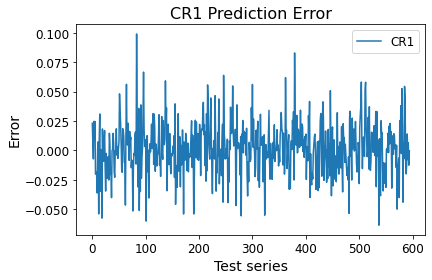

In [40]:
plot_PredictionError(modify_ylim=False)

Saving figure au150_DW_ann_xmu_cr1_200_20_1_run_2022_05_28-16_45_51_prediction_err_1


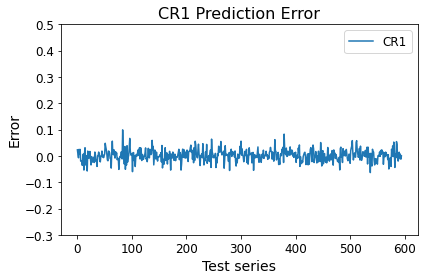

In [41]:
plot_PredictionError(modify_ylim=True, ylim=[-0.3,0.5], ind=1)

#### 直接比较

Saving figure au150_DW_ann_xmu_cr1_200_20_1_run_2022_05_28-16_45_51_prediction_compare_CR1_0
Saving figure au150_DW_ann_xmu_cr1_200_20_1_run_2022_05_28-16_45_51_prediction_compare_CR1_1
Saving figure au150_DW_ann_xmu_cr1_200_20_1_run_2022_05_28-16_45_51_prediction_compare_CR1_2


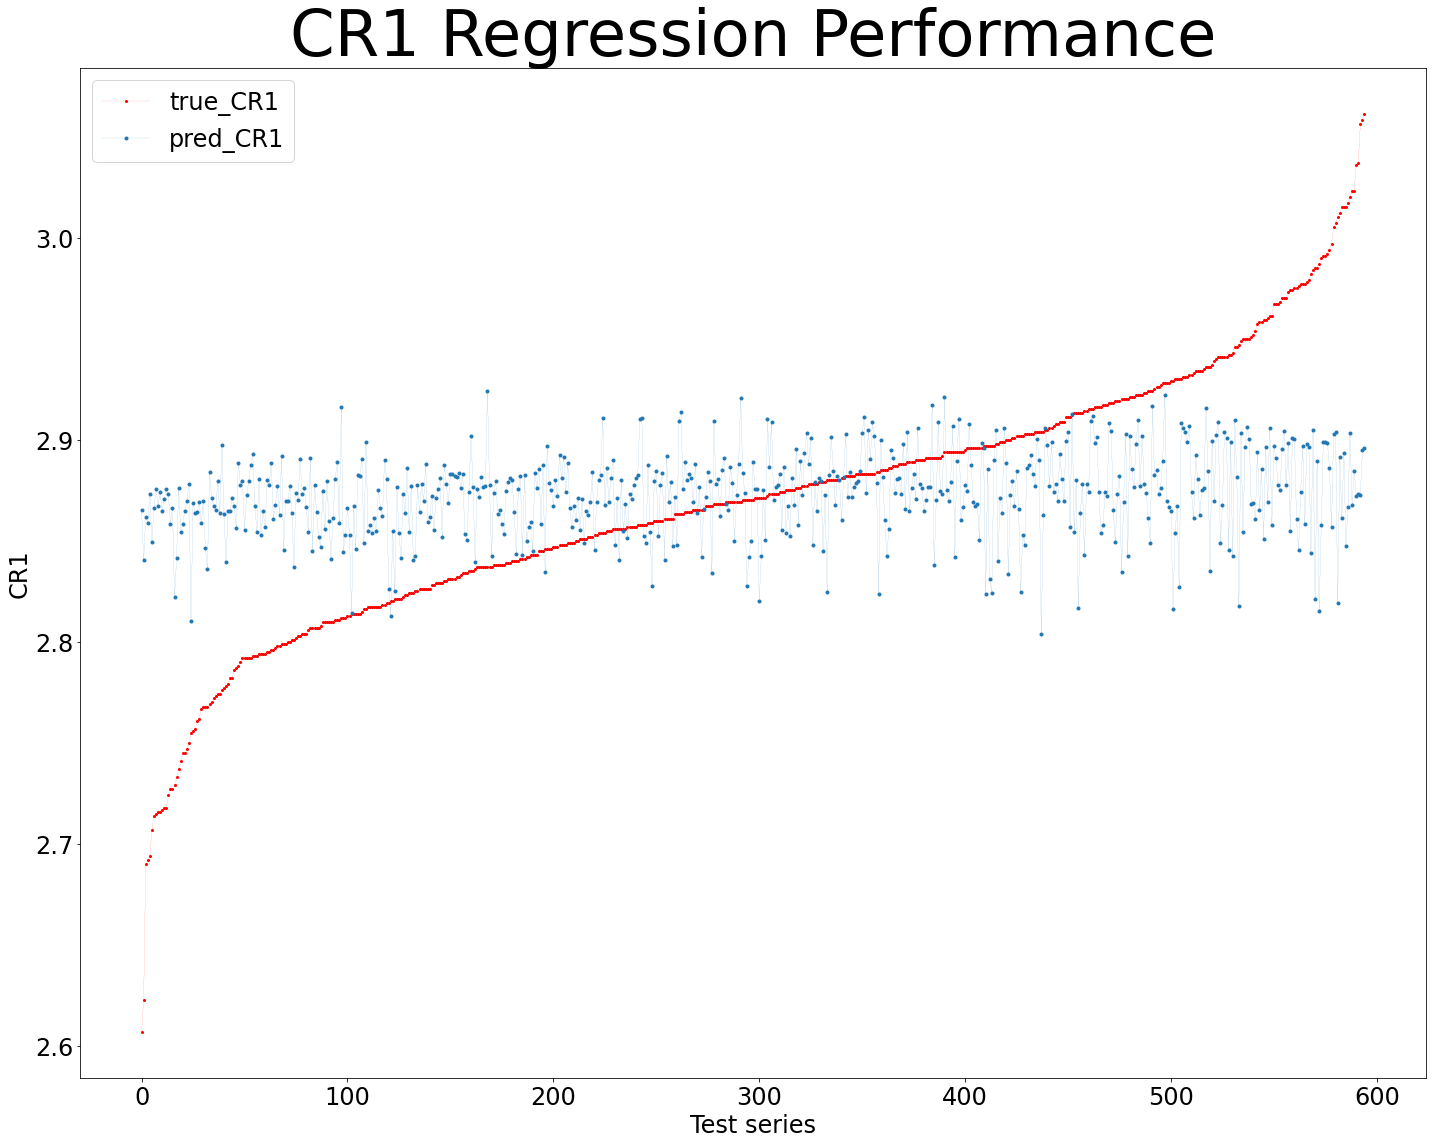

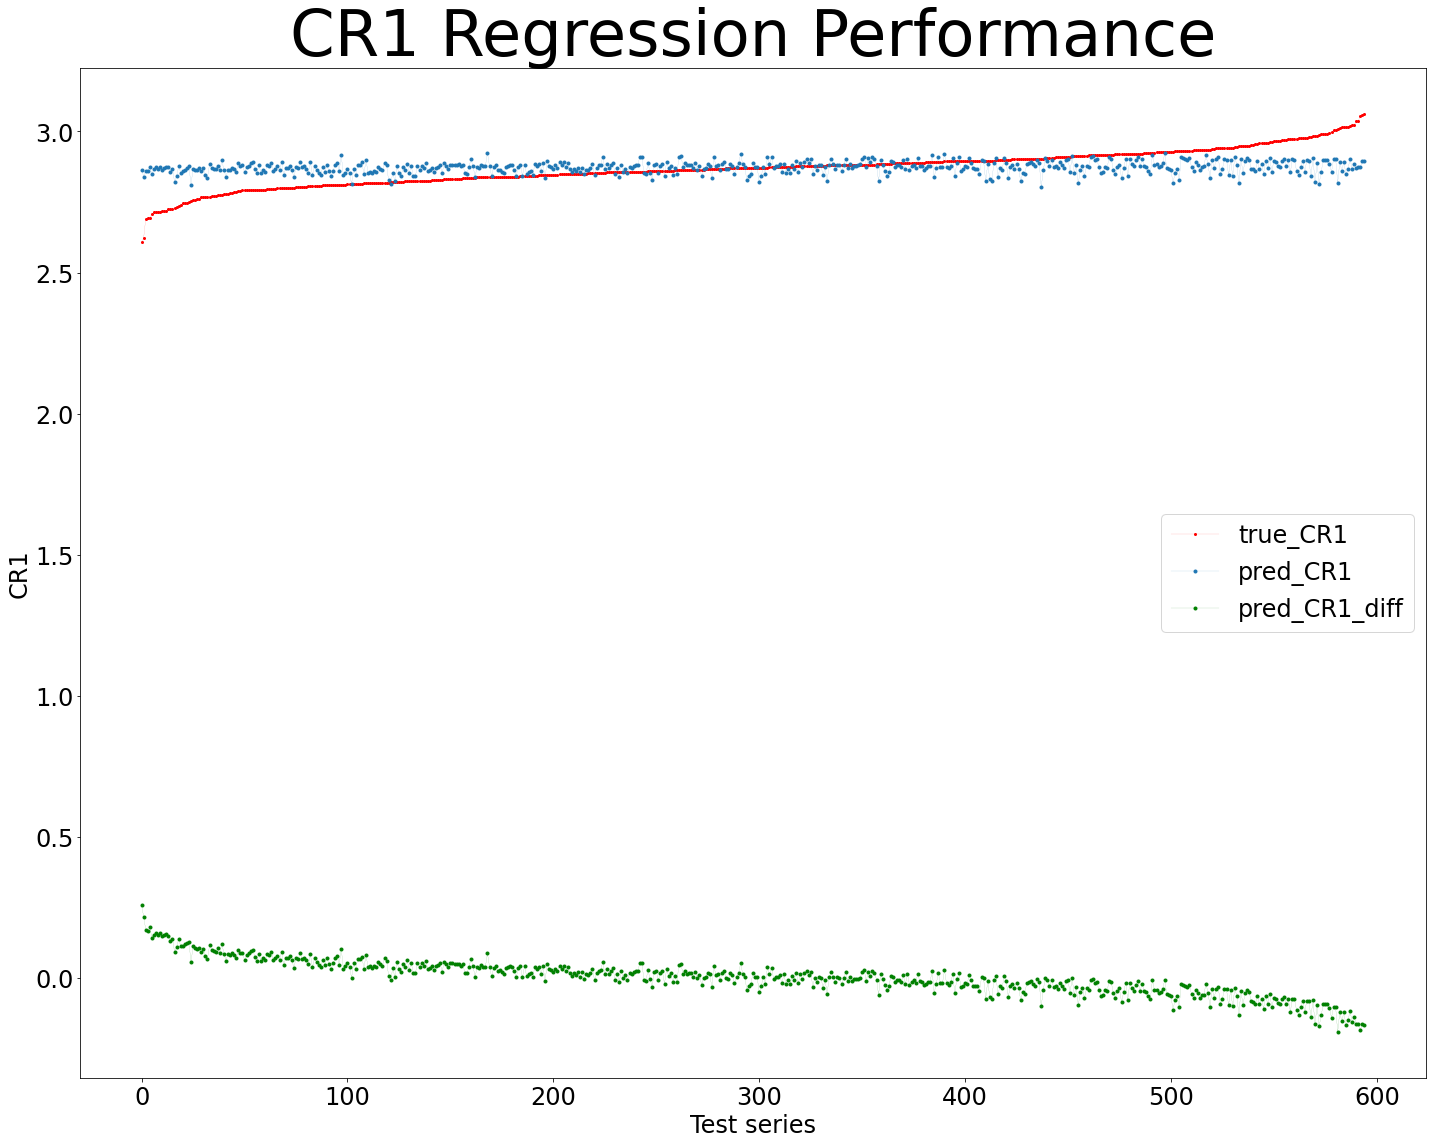

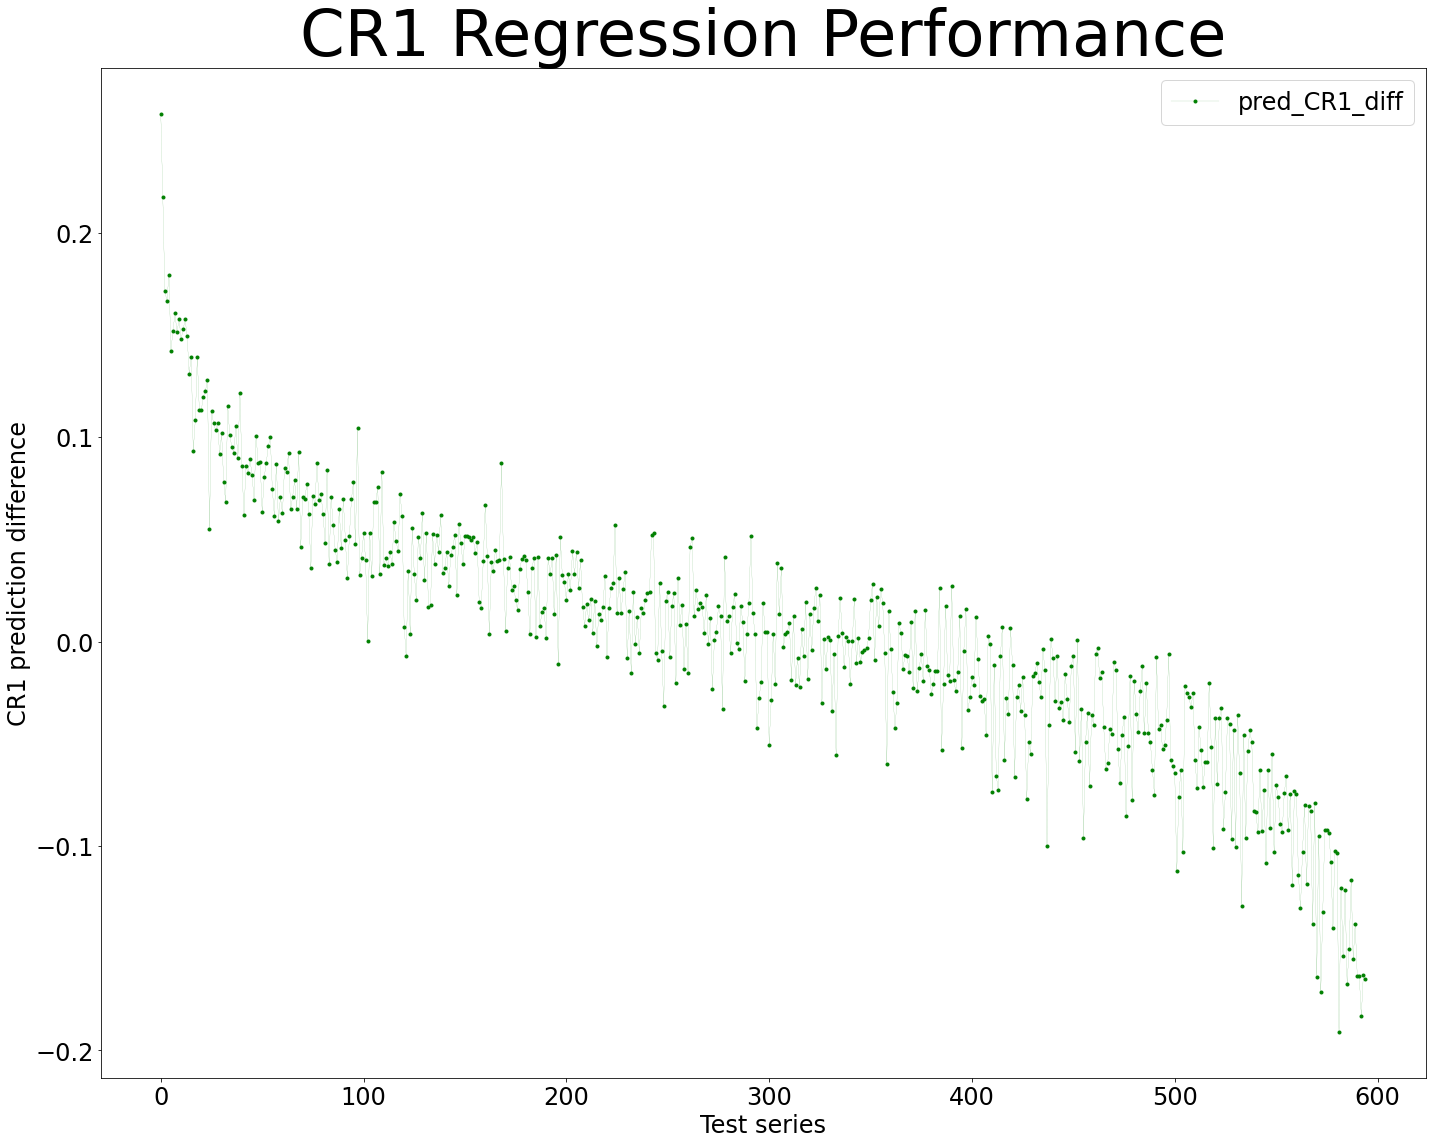

In [42]:
dict_plot_compareall = [{'ind':0, 'w_plot_label':True,  'w_plot_pred':True,  'w_plot_diff':False},
                        {'ind':1, 'w_plot_label':True,  'w_plot_pred':True,  'w_plot_diff':True},
                        {'ind':2, 'w_plot_label':False, 'w_plot_pred':False, 'w_plot_diff':True}
                       ]
for i, data in enumerate(dict_plot_compareall):
    ind = data['ind']
    w_plot_label = data['w_plot_label']
    w_plot_pred = data['w_plot_pred']
    w_plot_diff = data['w_plot_diff']
    prediction_compare_all(w_plot_label, w_plot_pred, w_plot_diff, ind)

#### 想画哪个就画哪个

Saving figure au150_DW_ann_xmu_cr1_200_20_1_run_2022_05_28-16_45_51_prediction_compare3_CR1_0_100


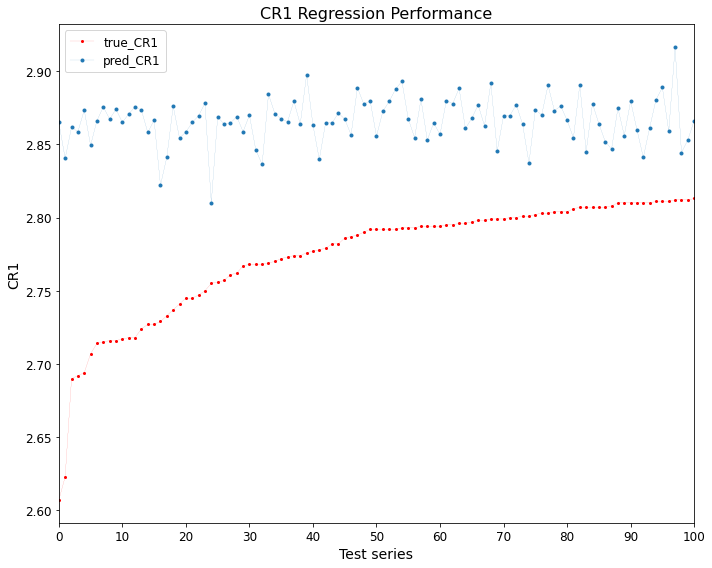

In [43]:
# x_low and x_high are the border of x-axis for plotting
x_low = 0
x_high = 100
# x_ticks is the step show for x-axis plottong
x_ticks = 10
plot_PredictionCompare3(x_low, x_high, x_ticks)

#### 分段直接比较

In [44]:
# 众多小图放置的文件夹
path_dir_pre = os.path.join(path_dir_ana, file_pre)

Saving figure prediction_compare_CR1_0_50
Saving figure prediction_compare_CR1_50_100
Saving figure prediction_compare_CR1_100_150
Saving figure prediction_compare_CR1_150_200
Saving figure prediction_compare_CR1_200_250
Saving figure prediction_compare_CR1_250_300
Saving figure prediction_compare_CR1_300_350
Saving figure prediction_compare_CR1_350_400
Saving figure prediction_compare_CR1_400_450
Saving figure prediction_compare_CR1_450_500
Saving figure prediction_compare_CR1_500_550
Saving figure prediction_compare_CR1_550_595


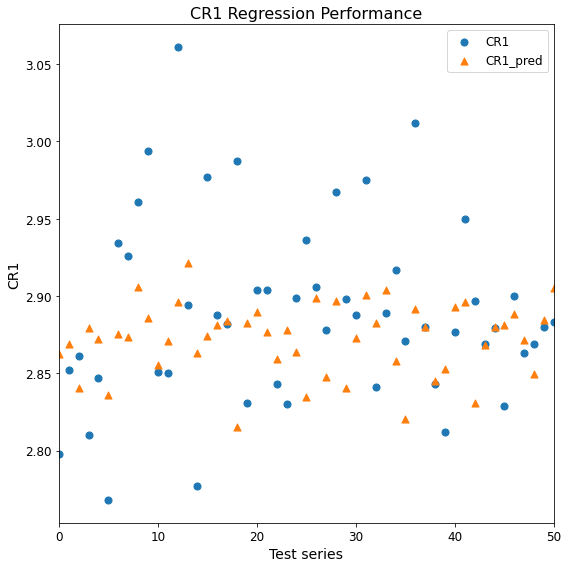

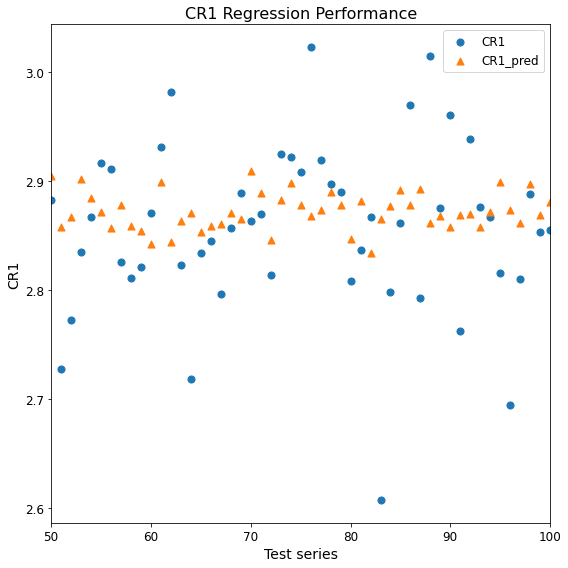

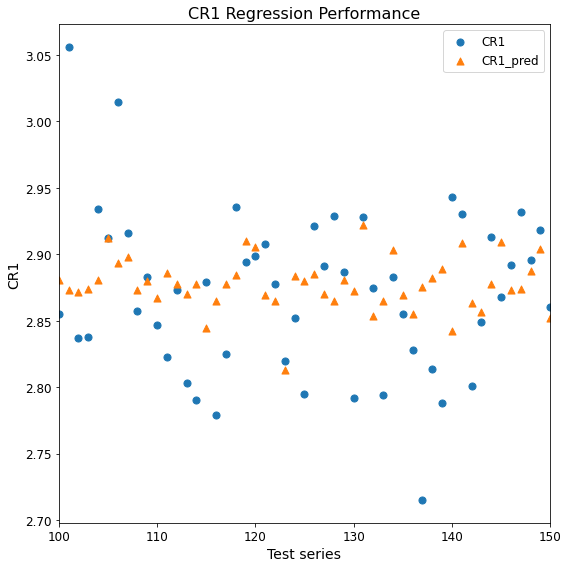

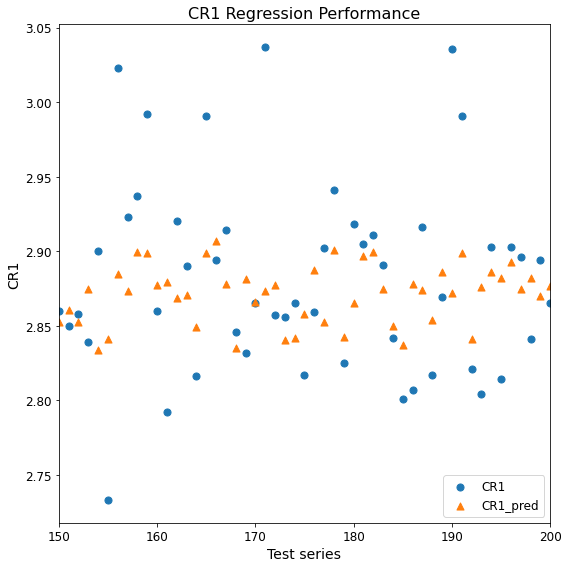

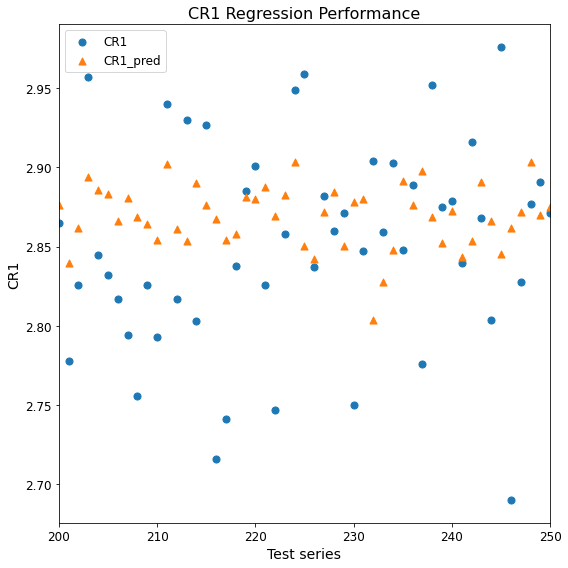

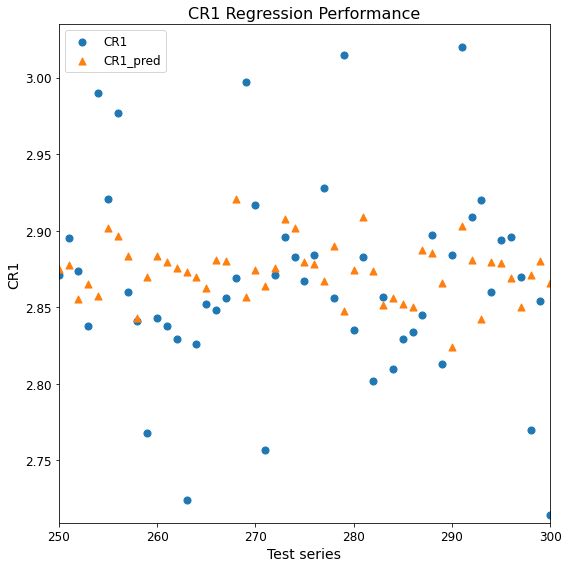

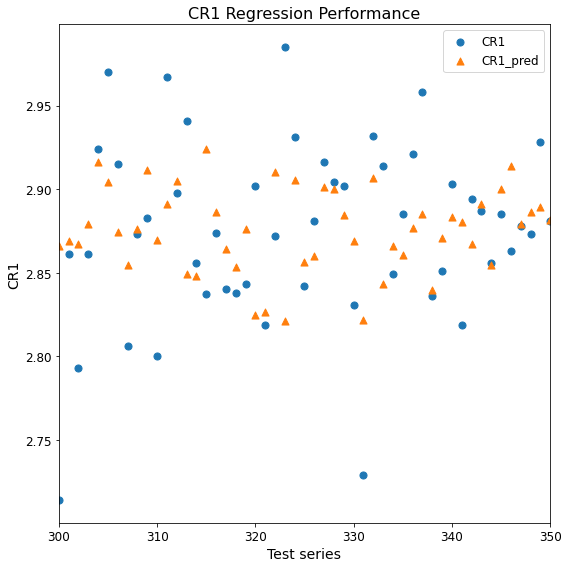

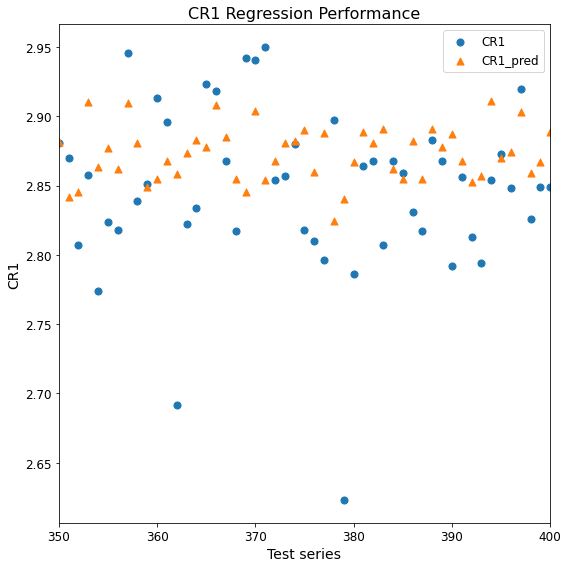

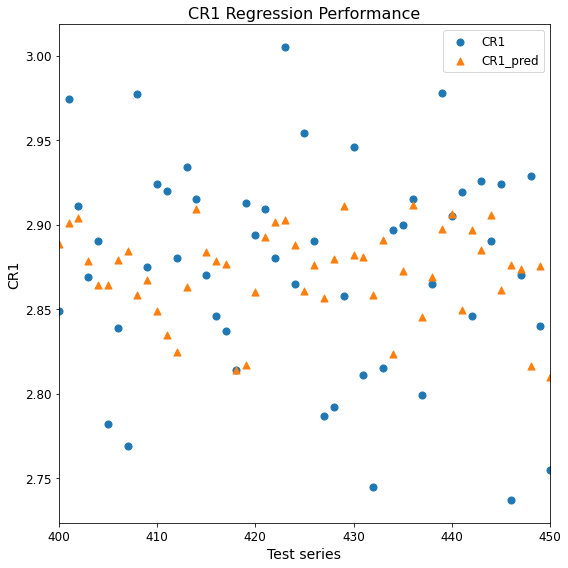

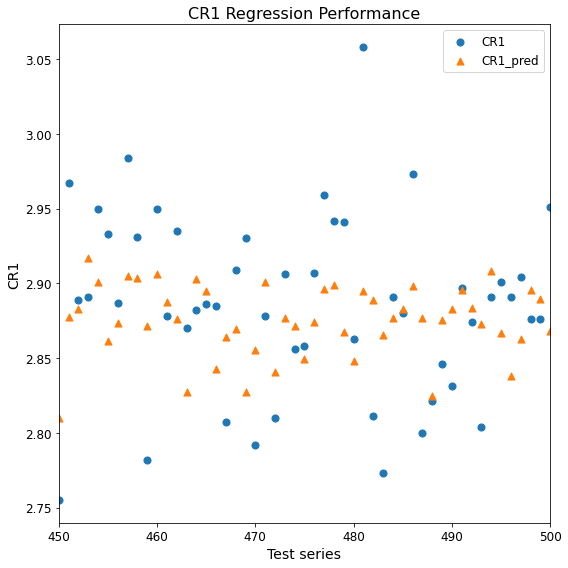

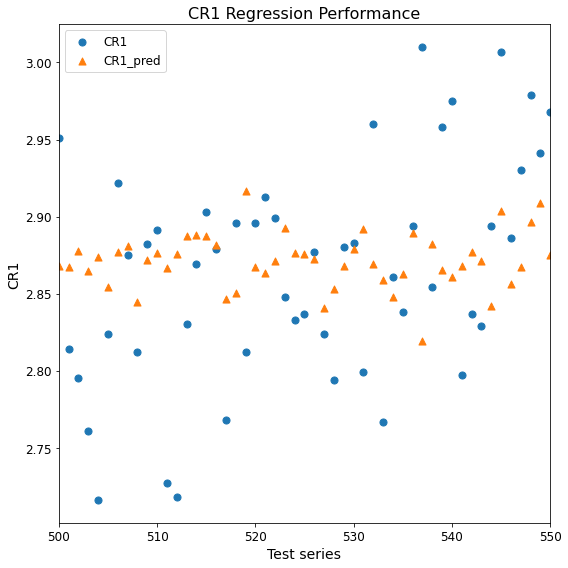

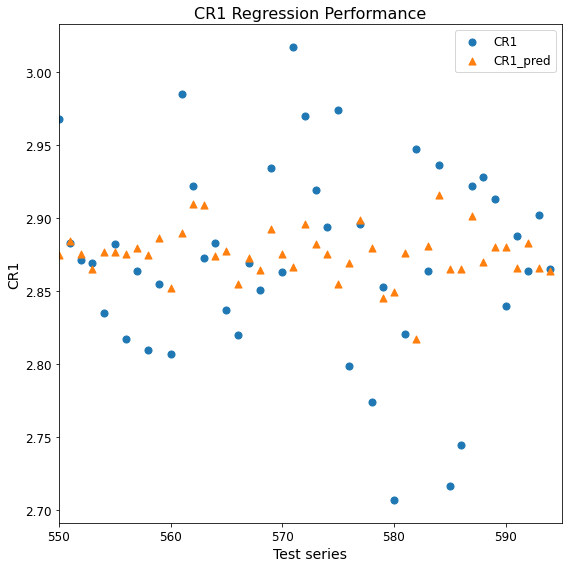

In [45]:
interval = 50
for i in range(0, pred.size, interval):
    plot_PredictionCompare(i, min(i+interval, pred.size))

###### 不同颜色（线条）

Saving figure prediction_compare2_CR1_0_50
Saving figure prediction_compare2_CR1_50_100
Saving figure prediction_compare2_CR1_100_150
Saving figure prediction_compare2_CR1_150_200
Saving figure prediction_compare2_CR1_200_250
Saving figure prediction_compare2_CR1_250_300
Saving figure prediction_compare2_CR1_300_350
Saving figure prediction_compare2_CR1_350_400
Saving figure prediction_compare2_CR1_400_450
Saving figure prediction_compare2_CR1_450_500
Saving figure prediction_compare2_CR1_500_550
Saving figure prediction_compare2_CR1_550_595


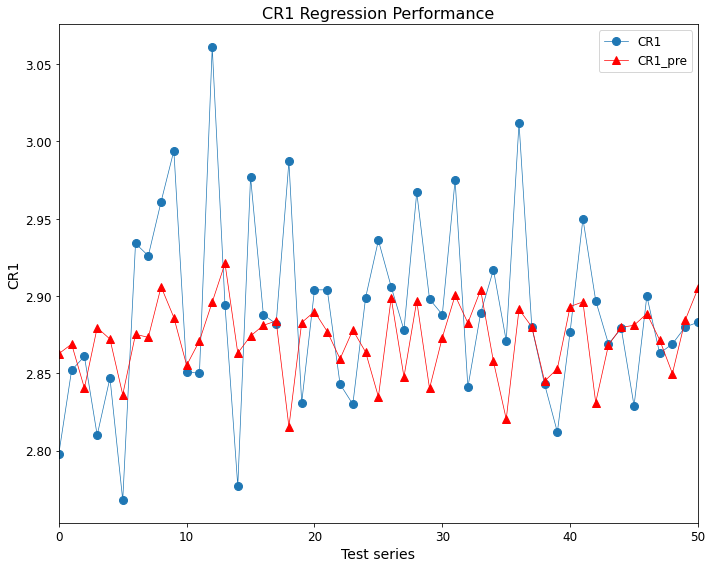

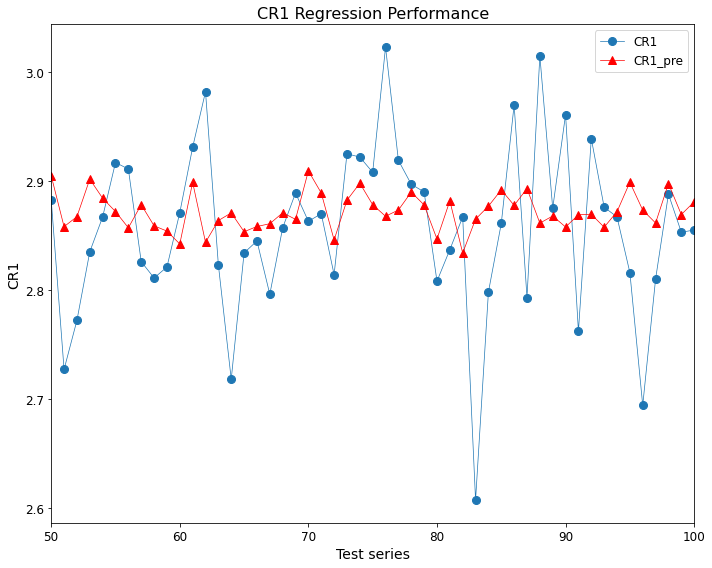

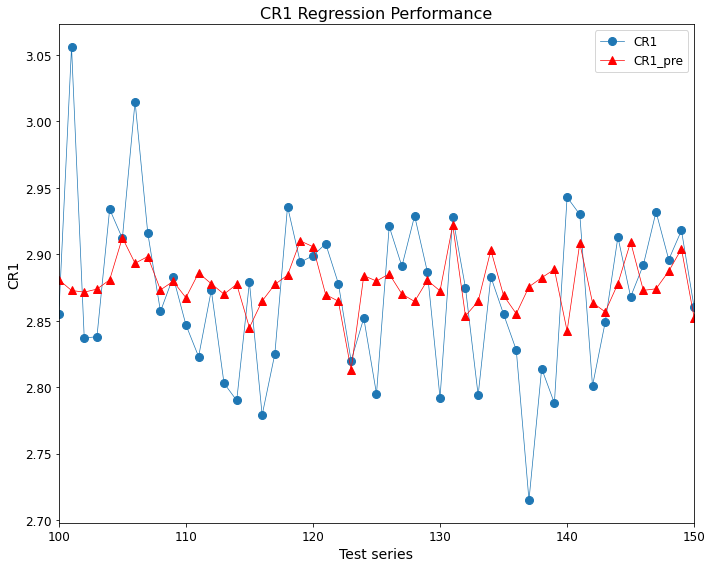

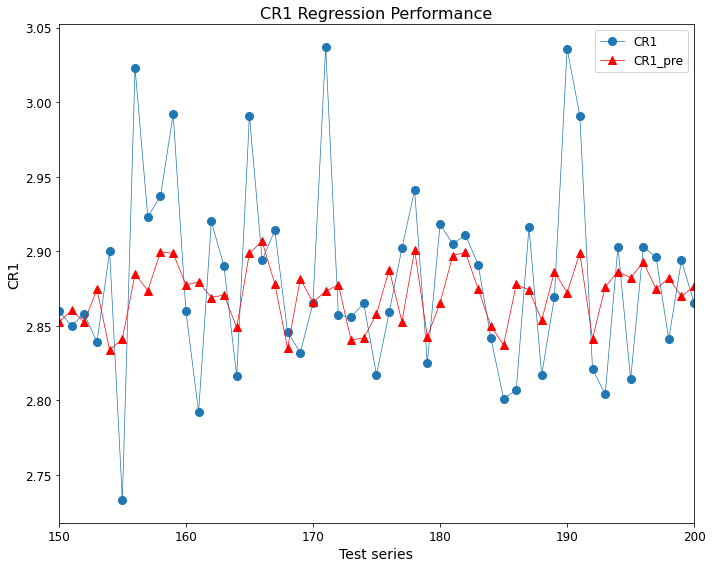

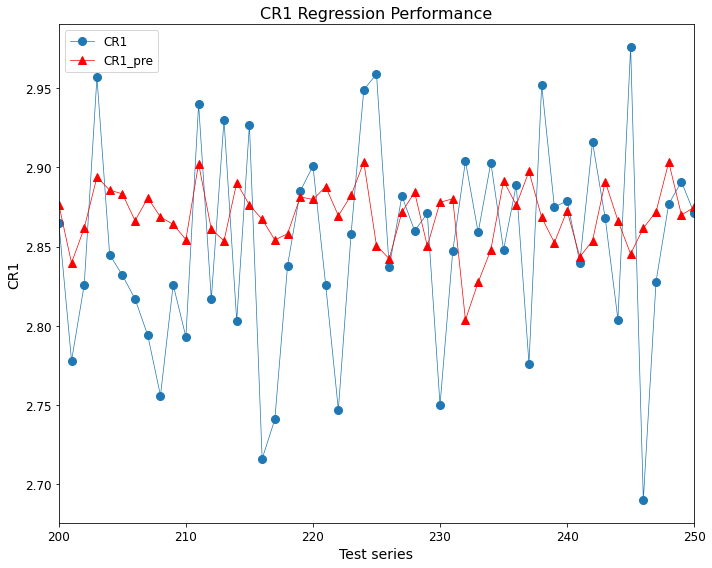

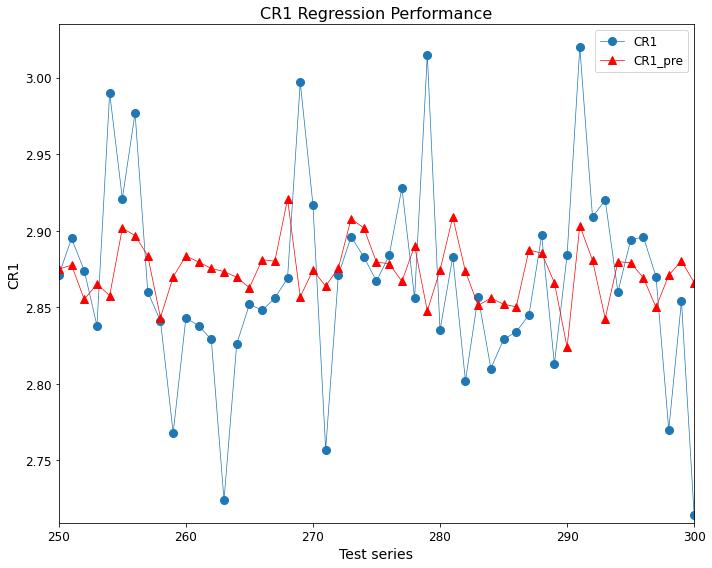

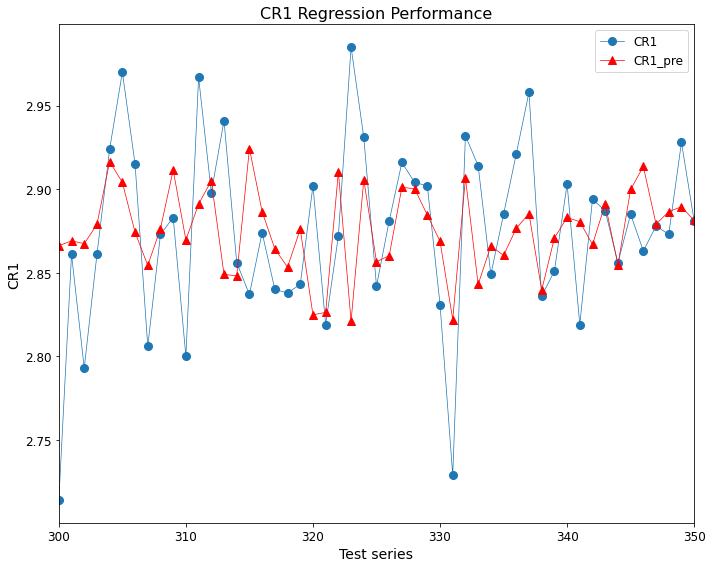

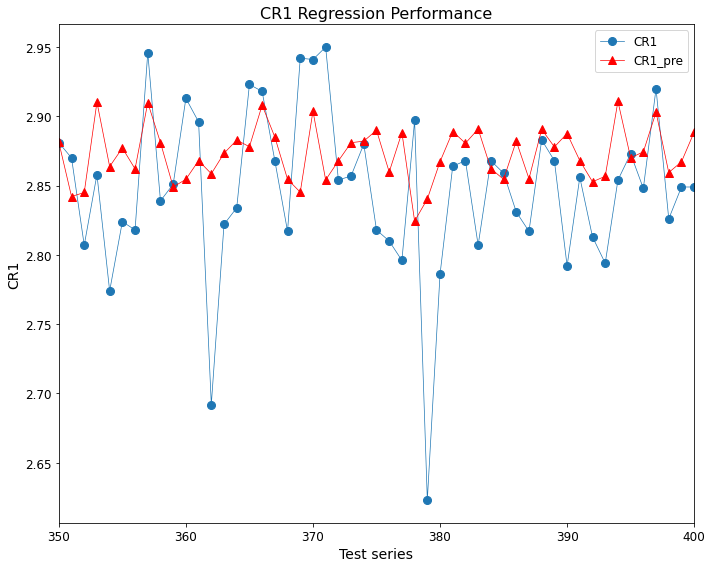

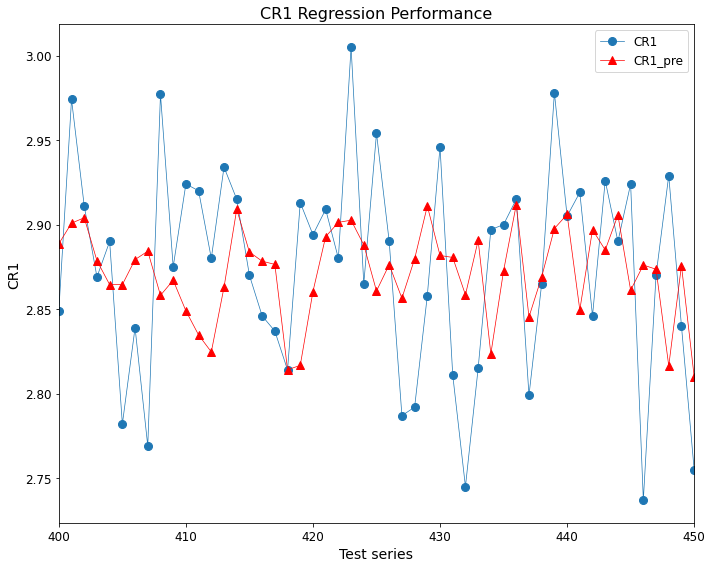

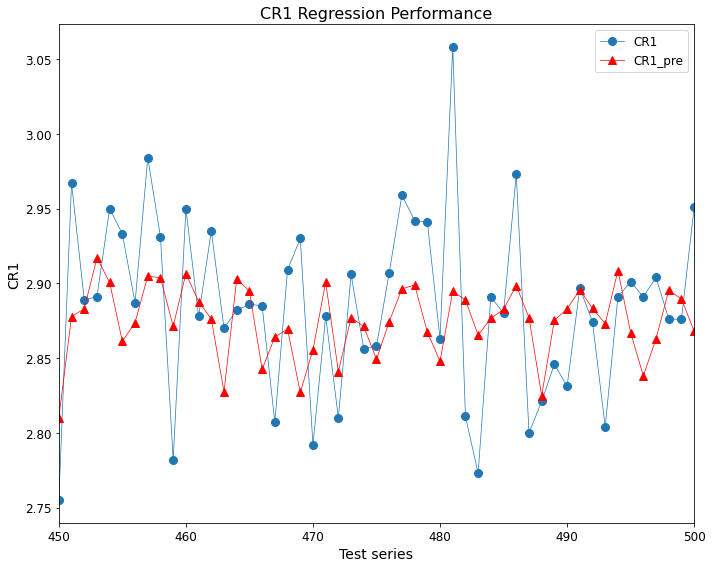

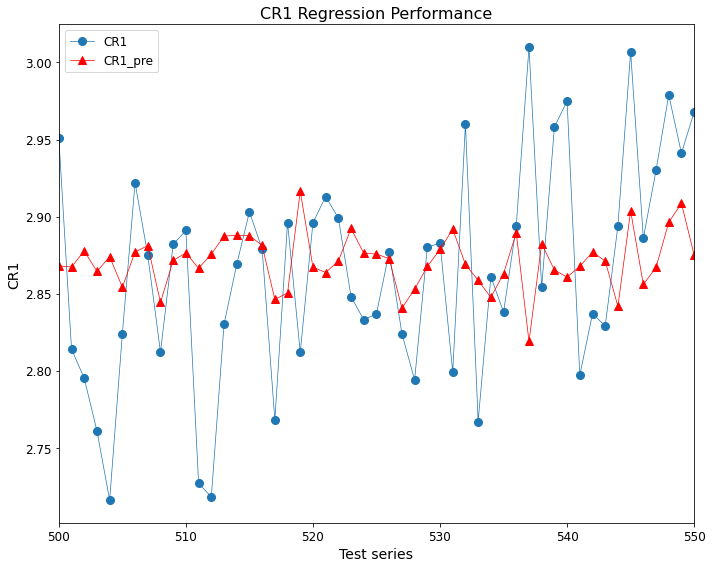

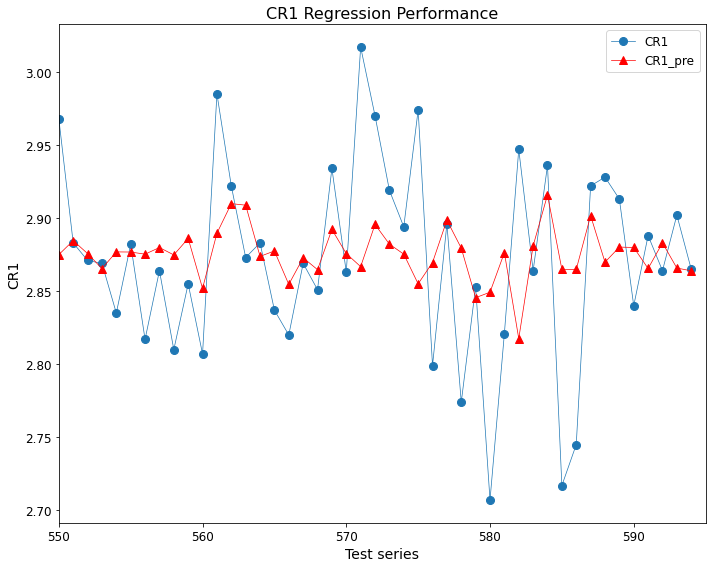

In [46]:
interval = 50
for i in range(0,pred.size, interval):
    plot_PredictionCompare2(i, min(i+interval, pred.size))

#### parity chart for label

Saving figure au150_DW_ann_xmu_cr1_200_20_1_run_2022_05_28-16_45_51_parity_pred
Saving figure au150_DW_ann_xmu_cr1_200_20_1_run_2022_05_28-16_45_51_parity_diff
Saving figure au150_DW_ann_xmu_cr1_200_20_1_run_2022_05_28-16_45_51_parity_err


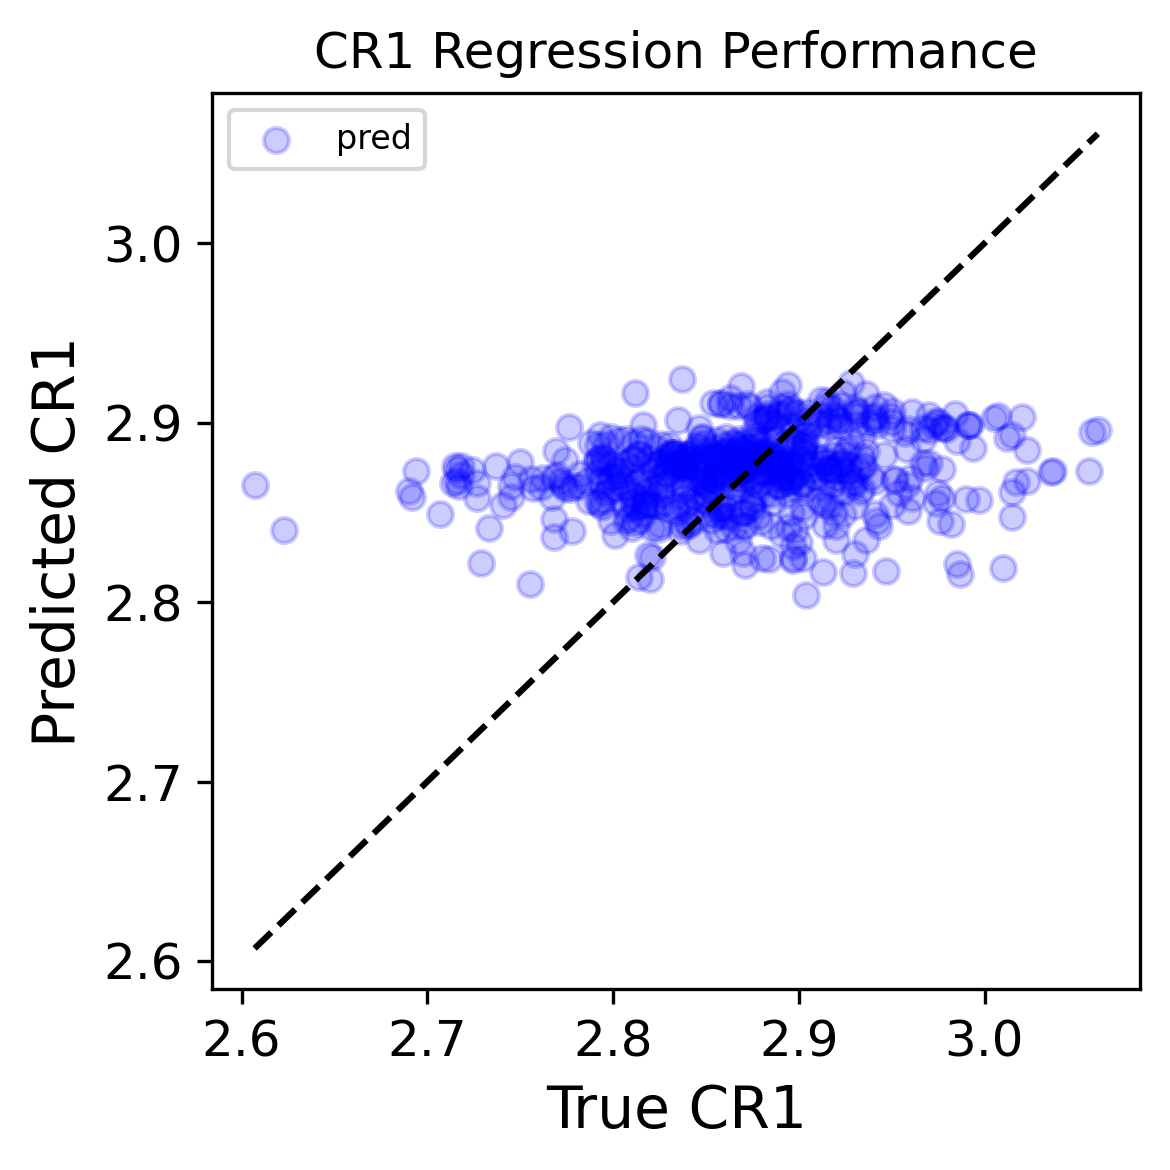

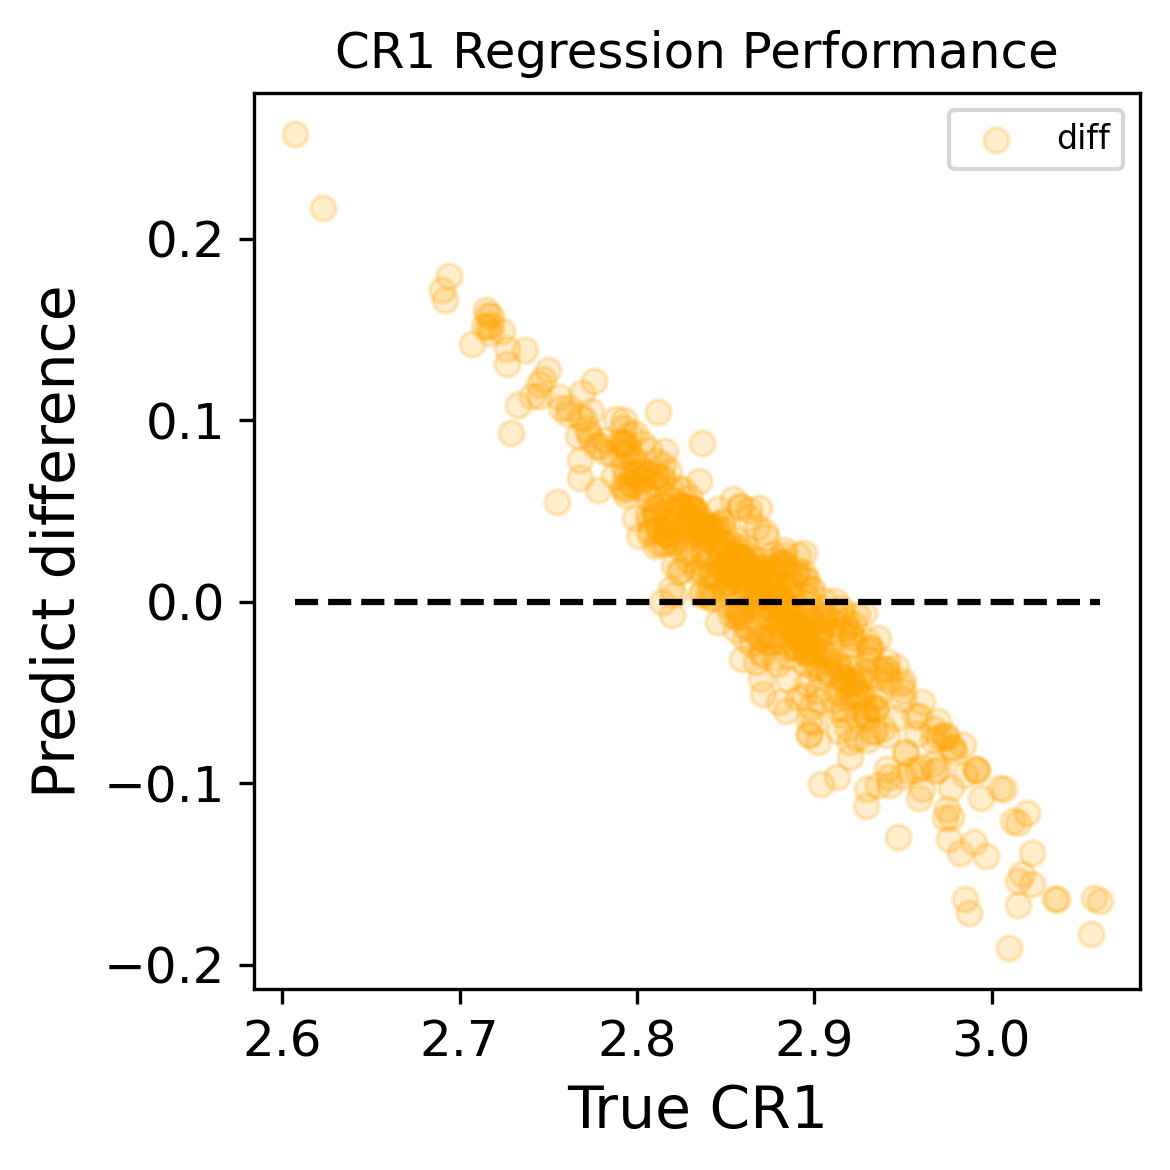

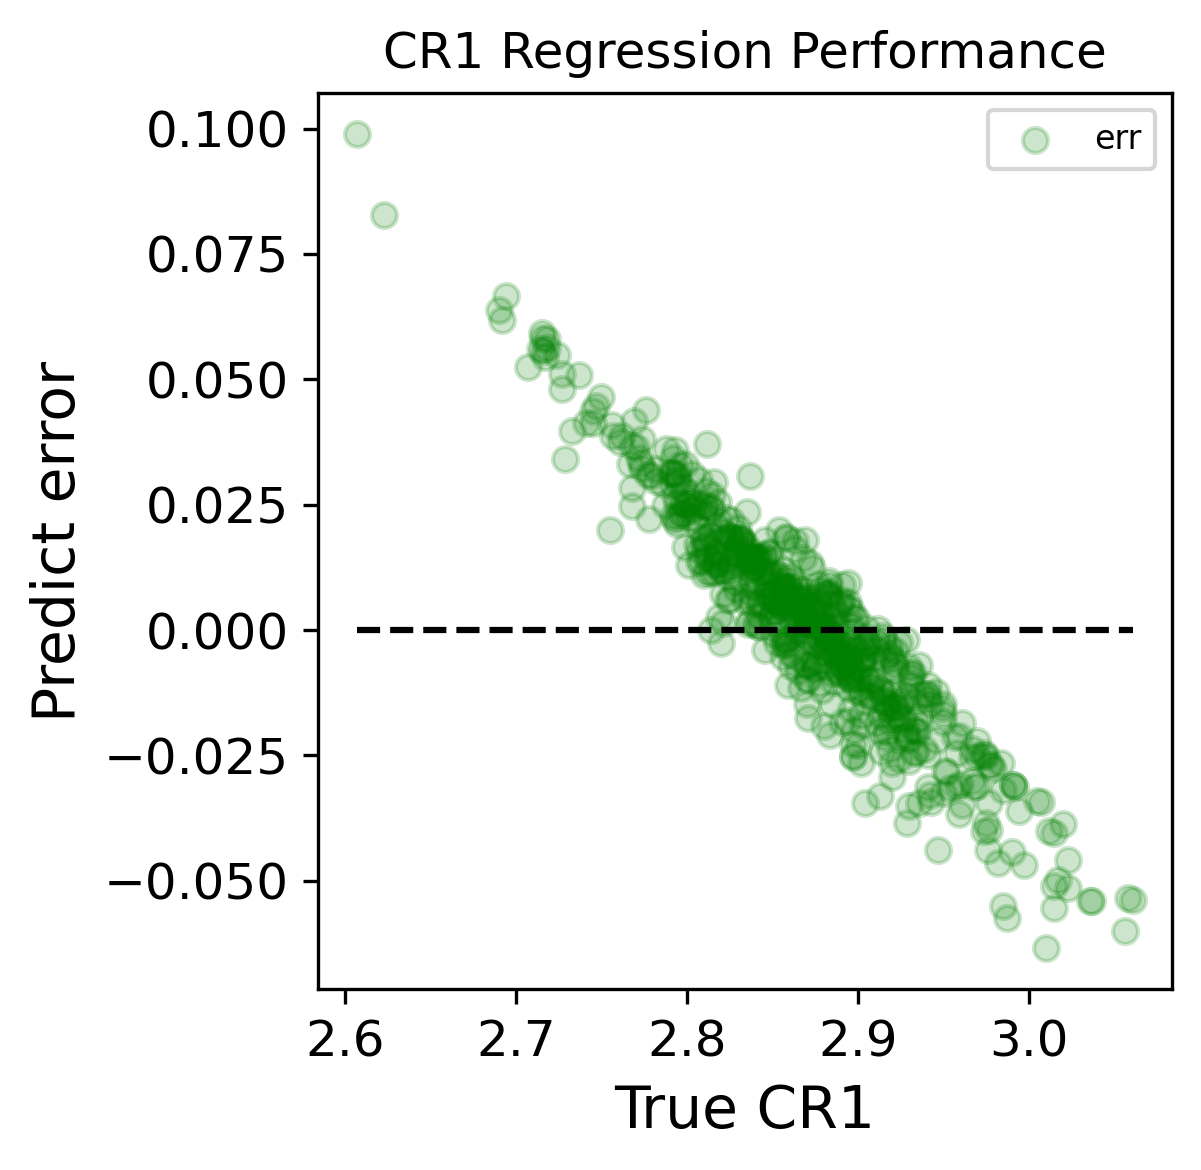

In [47]:
dict_plot_parity = [{'legend':'pred', 'sts':pred, 'color':'blue',   'ylabel':f"Predicted {label_index}"},
                    {'legend':'diff', 'sts':diff, 'color':'orange', 'ylabel':'Predict difference'},
                    {'legend':'err',  'sts':err,  'color':'green',  'ylabel':'Predict error'},
                ]
for i, data in enumerate(dict_plot_parity):
    legend = data['legend']
    sts = data['sts']
    color = data['color']
    ylabel = data['ylabel']
    file = file_pre + '_parity_' + legend
    plot_parity(file, sts, color, legend, ylabel)

## 各个label（区间）分析

### 基本设置

In [48]:
label_type = dict_label['type']
step_label = dict_label['step']
step_pred = dict_pred['step']
step_err = dict_pred['step_err']
#
dc= label_type
if label_type == 'd':
    step_label = 0
elif label_type == 'c':
    step_label = step_label
else:
    print()
    print(f"** Error!! label type is {label_type}, Not continuous nor Dispersed!")
    sys.exit()
#
digit_step_label = digit_dot(step_label)
digit_step_pred = digit_dot(step_pred)
digit_step_err = digit_dot(step_err)
#

### txt文档格式设置

In [49]:
str_no = 'No.'
str_lab_ind = 'Label_index'
str_lab = 'label'
str_pred = 'Predict'
str_diff = 'Diff'
str_diff_abs = '|Diff|'
str_err = 'Error'
str_err_abs = '|Error|'
str_avg = 'Average'
str_var = 'Variance(MSE)'
str_std = 'Std. Dev.(RMSE)'
str_intv = 'Interval'
str_amt = 'Amount'
str_list = 'Pred_list'
# n_xx 是输出格式中各列的占位数
# delta, the number of additiaonal digit of prediction than label
delta = 2
n_maxnd_label = len(str(label.size))                        # label的个数，如1万，则需要5位数
#
# No.
n_no = max(n_maxnd_label, len(str_no))
#
# label index
n_lab_ind = max(n_maxnd_label, len(str_lab_ind))
#
#  label
#  label在[]区间中的显示长度（单个）
if dc == 'c':
    n_lab_int = n_lab_before_dot + 1 + digit_step_label
n_lab = max(n_lab_self, len(str_lab))
#
# prediction
#  prediction 在[]区间中的显示长度（单个）
n_pred_int = n_pred_before_dot + 1 + digit_step_pred
if digit_step_pred == 0:
    n_pred_int = n_pred_before_dot
n_pred = max(n_pred_self, len(str_pred))
#
#  diff
n_diff_int = n_diff_before_dot + 1 + digit_step_pred
if digit_step_pred == 0:
    n_diff_int = n_diff_before_dot
n_diff = max(n_diff_self, len(str_diff))
#
# diff_abs
n_diff_abs_int = n_diff_abs_before_dot + 1 + digit_step_pred
if digit_step_pred == 0:
    n_diff_abs_int = n_diff_abs_before_dot
n_diff_abs = max(n_diff_abs_self, len(str_diff_abs))
#
# err
# error 表示为-2.738E-02
n_err = max(n_err_self, len(str_err))
# for error plot, we need know the digit before dot.
n_err_before_dot = 0
for data in err.flatten():
    n_err_before_dot = max(n_err_before_dot, digit_dot(data, before_dot=True))
n_err_int = n_err_before_dot + 1 + digit_step_err
if digit_step_err == 0:
    n_err_int = n_err_before_dot
#
#  err_abs
n_err_abs = max(n_err_abs_self, len(str_err_abs))
n_err_abs_before_dot = 0
for data in err_abs.flatten():
    n_err_abs_before_dot = max(n_err_abs_before_dot, digit_dot(data, before_dot=True))
n_err_abs_int = n_err_abs_before_dot + 1 + digit_step_err
if digit_step_err == 0:
    n_err_abs_int = n_err_abs_before_dot
#
# Interval
n_pred_intv_int = n_pred_int * 2 + 3
n_intv = max(n_pred_intv_int, len(str_intv))
#
#  Amount
n_amt = max(n_maxnd_label, len(str_amt))
#
#  Pred_list
n_list = len(str_list)
#
#
n_avg_var_std = max(len(str_avg), len(str_var), len(str_std))
n_no_lab_ind = n_no + 1 + n_lab_ind
head = n_no_lab_ind - n_avg_var_std
if head > 0:
    n_head_no = 0
    n_head_avg = head
elif n_no_lab_ind == n_avg_var_std:
    n_head_no = 0
    n_head_avg = 0
else:
    n_head_no = abs(head)
    n_head_avg = 0
n_all = n_head_no + n_no + 1 + n_lab_ind + 1 + n_lab + 1 + n_pred + 1 + n_diff + 1 + n_diff_abs + 1 + n_err + 1 + n_err_abs

### Error统计绘图、txt输出

In [50]:
label_analysis(label, step_label, dc)
list_plot_txt = [{'tag':'Err',      'sts':err,      'step':step_err,  'iserr':True,  'note_in_txt':'Predict Error Distribution',      'n_sts_int':n_err_int},
                 {'tag':'Err_Abs',  'sts':err_abs,  'step':step_err,  'iserr':True,  'note_in_txt':'Predict Error Abs. Distribution', 'n_sts_int':n_err_abs_int},
                 {'tag':'Diff',     'sts':diff,     'step':step_pred, 'iserr':True,  'note_in_txt':'Predict Diff Distribution',       'n_sts_int':n_diff_int},
                 {'tag':'Diff_Abs', 'sts':diff_abs, 'step':step_pred, 'iserr':True,  'note_in_txt':'Predict Diff Abs. Distribution',  'n_sts_int':n_diff_abs_int},
                 {'tag':'Pred',     'sts':pred,     'step':step_pred, 'iserr':False, 'note_in_txt':'Predict Distribution',            'n_sts_int':n_pred_int}
                ]
for i,a in enumerate(list_plot_txt):
    tag         = a['tag']
    sts         = a['sts']
    step        = a['step']
    iserr       = a['iserr']
    note_in_txt = a['note_in_txt']
    n_sts_int   = a['n_sts_int']
# statistics
    err_min, err_max, ERR, ERR_min, ERR_max, dim_err_min, dim_err, N_err, ERR_all_sum = error_distribute(sts, step)
# plot with different label
    plot_err(step, tag, err_min, err_max, ERR, ERR_min, ERR_max, dim_err_min, iserr)
# plot all label in one
    file = f"{file_pre}_pred_dist_{tag.lower()}_step={step}"
    label_note = f"{feature_index}/{label_index}"
    if iserr:
        plot_pred_label_err(dc, label_min, label_max, np.min(sts), np.max(sts), list(N_err), 0, dim_err-1, dim_err_min, step, path_dir_ana, file, label_index, label_note, tag, w_all=True)
    else:
        plot_pred_label(dc, label_min, label_max, list(N_err), 0, dim_err-1, dim_err_min, step, path_dir_ana, file, label_index, label_note, w_all=True)
#
# writeout to txt
    file_txt = f"{file_pre}_pred_dist_{tag.lower()}_step={step}.txt"
    path_file_txt = os.path.join(path_dir_ana, file_txt)
    digit_step = digit_dot(step)
    err_dist2txt(path_file_txt, note_in_txt, N_err, dim_err_min, dim_err, step, digit_step, ERR_min, ERR_max, ERR, ERR_all_sum, n_sts_int)
#

Saving figure xmu_CR1_err_2.6_step=0.01
Saving figure xmu_CR1_err_2.62_step=0.01
Saving figure xmu_CR1_err_2.68_step=0.01
Saving figure xmu_CR1_err_2.7_step=0.01
Saving figure xmu_CR1_err_2.72_step=0.01
Saving figure xmu_CR1_err_2.74_step=0.01
Saving figure xmu_CR1_err_2.76_step=0.01
Saving figure xmu_CR1_err_2.78_step=0.01
Saving figure xmu_CR1_err_2.8_step=0.01
Saving figure xmu_CR1_err_2.82_step=0.01
Saving figure xmu_CR1_err_2.84_step=0.01
Saving figure xmu_CR1_err_2.86_step=0.01
Saving figure xmu_CR1_err_2.88_step=0.01
Saving figure xmu_CR1_err_2.9_step=0.01
Saving figure xmu_CR1_err_2.92_step=0.01
Saving figure xmu_CR1_err_2.94_step=0.01
Saving figure xmu_CR1_err_2.96_step=0.01
Saving figure xmu_CR1_err_2.98_step=0.01
Saving figure xmu_CR1_err_3.0_step=0.01
Saving figure xmu_CR1_err_3.02_step=0.01
Saving figure xmu_CR1_err_3.04_step=0.01
Saving figure xmu_CR1_err_3.06_step=0.01
Saving figure au150_DW_ann_xmu_cr1_200_20_1_run_2022_05_28-16_45_51_pred_dist_err_step=0.01
***** Label

Saving figure xmu_CR1_diff_2.62_step=0.02
Saving figure xmu_CR1_diff_2.68_step=0.02
Saving figure xmu_CR1_diff_2.7_step=0.02
Saving figure xmu_CR1_diff_2.72_step=0.02
Saving figure xmu_CR1_diff_2.74_step=0.02
Saving figure xmu_CR1_diff_2.76_step=0.02
Saving figure xmu_CR1_diff_2.78_step=0.02
Saving figure xmu_CR1_diff_2.8_step=0.02
Saving figure xmu_CR1_diff_2.82_step=0.02
Saving figure xmu_CR1_diff_2.84_step=0.02
Saving figure xmu_CR1_diff_2.86_step=0.02
Saving figure xmu_CR1_diff_2.88_step=0.02
Saving figure xmu_CR1_diff_2.9_step=0.02
Saving figure xmu_CR1_diff_2.92_step=0.02
Saving figure xmu_CR1_diff_2.94_step=0.02
Saving figure xmu_CR1_diff_2.96_step=0.02
Saving figure xmu_CR1_diff_2.98_step=0.02
Saving figure xmu_CR1_diff_3.0_step=0.02
Saving figure xmu_CR1_diff_3.02_step=0.02
Saving figure xmu_CR1_diff_3.04_step=0.02
Saving figure xmu_CR1_diff_3.06_step=0.02
Saving figure au150_DW_ann_xmu_cr1_200_20_1_run_2022_05_28-16_45_51_pred_dist_diff_step=0.02
***** Label      : ./../datas

Saving figure xmu_CR1_pred_2.62_step=0.02
Saving figure xmu_CR1_pred_2.68_step=0.02
Saving figure xmu_CR1_pred_2.7_step=0.02
Saving figure xmu_CR1_pred_2.72_step=0.02
Saving figure xmu_CR1_pred_2.74_step=0.02
Saving figure xmu_CR1_pred_2.76_step=0.02
Saving figure xmu_CR1_pred_2.78_step=0.02
Saving figure xmu_CR1_pred_2.8_step=0.02
Saving figure xmu_CR1_pred_2.82_step=0.02
Saving figure xmu_CR1_pred_2.84_step=0.02
Saving figure xmu_CR1_pred_2.86_step=0.02
Saving figure xmu_CR1_pred_2.88_step=0.02
Saving figure xmu_CR1_pred_2.9_step=0.02
Saving figure xmu_CR1_pred_2.92_step=0.02
Saving figure xmu_CR1_pred_2.94_step=0.02
Saving figure xmu_CR1_pred_2.96_step=0.02
Saving figure xmu_CR1_pred_2.98_step=0.02
Saving figure xmu_CR1_pred_3.0_step=0.02
Saving figure xmu_CR1_pred_3.02_step=0.02
Saving figure xmu_CR1_pred_3.04_step=0.02
Saving figure xmu_CR1_pred_3.06_step=0.02
Saving figure au150_DW_ann_xmu_cr1_200_20_1_run_2022_05_28-16_45_51_pred_dist_pred_step=0.02
***** Label      : ./../datas

### 独立label统计分析输出

In [51]:
file_label_indiv_statistics_txt = f"{file_pre}_indiv_statistics_step={step_pred}.txt"
path_label_indiv_statistics_txt = os.path.join(path_dir_ana, file_label_indiv_statistics_txt)
pred_analysis()
list_pred = list_rerange(dim_label, ERR_min, ERR_max, ERR)

a = []
b = [1]
c = [2,4]
a + b + c + [2] = [1, 2, 4, 2]

In [52]:
fout = open(path_label_indiv_statistics_txt,'w')
#
# input
global pred, step_pred
global dc
global list_lab

#
#global dir_model, file_saved_model, dir_feature, file_feature_test, dir_label, file_label, dir_pred, file_pred
global dir_label, file_label, dir_pred, file_pred
global label_index
#
trivial = 0.00001
if step_pred > 0:
    trivial = min(trivial, step_pred/100)
#
#***** Model   : ./../nn_train/au150_DW_ann_chi_cr1_200_20_1_run_2022_05_28-15_27_10.h5
#***** Fearute : ./../datasets/Au_chi_test.txt
#***** Label   : ./../datasets/Au_cr1_test.txt
#Total   : 595 data
#
# Title
#print(f"{'*'*5} Model      : {dir_model}/{file_saved_model}")
#print(f"{'*'*5} Fearute    : {dir_feature}/{file_feature_test}")
print(f"{'*'*5} Label      : {dir_label}/{file_label}")
print(f"{'*'*5} Prediction : {dir_pred}/{file_pred}")
#print(f"{'*'*5} Model      : {dir_model}/{file_saved_model}", file=fout)
#print(f"{'*'*5} Fearute    : {dir_feature}/{file_feature_test}", file=fout)
print(f"{'*'*5} Label      : {dir_label}/{file_label}", file=fout)
print(f"{'*'*5} Prediction : {dir_pred}/{file_pred}", file=fout)
print(f"Total   : {pred.size} data")
print(f"Total   : {pred.size} data", file=fout)
#
for i in range(dim_label):

    if dc == 'd':
        label_value = list_lab[i]
#
#******************** No. 1 --- label CN1 = 8.0 ********************
        j = 1+3+1+2+1+3+1+5+1+len(label_index)+3+n_lab+1
        n_star = int((n_all - j)/2)
        print(f"\n\n{'*'*(n_star)} No. {i+1} {'-'*3} label {label_index} = {label_value:>{n_lab_self}.{n_lab_after_dot}f} {'*'*(n_star)}")
        print(f"\n\n{'*'*(n_star)} No. {i+1} {'-'*3} label {label_index} = {label_value:>{n_lab_self}.{n_lab_after_dot}f} {'*'*(n_star)}", file=fout)
    elif dc == 'c':
        label_int_min = round(list_lab[i], ndigits = digit_step_label)
        label_int_max = round(list_lab[i]+step_label, ndigits = digit_step_label)
#
#******************** No. 1 --- label CR1 = [ 2.60, 2.65) ********************
        j = 1+3+1+2+1+3+1+5+1+len(label_index)+4+n_lab_int+1+1+n_lab_int+1+1+1
        n_star = int((n_all - j)/2)
        print(f"\n\n{'*'*(n_star)} No. {i+1} {'-'*3} label {label_index} = [{label_int_min:>{n_lab_int+1}.{digit_step_label}f},{label_int_max:>{n_lab_int+1}.{digit_step_label}f}) {'*'*(n_star)}")
        print(f"\n\n{'*'*(n_star)} No. {i+1} {'-'*3} label {label_index} = [{label_int_min:>{n_lab_int+1}.{digit_step_label}f},{label_int_max:>{n_lab_int+1}.{digit_step_label}f}) {'*'*(n_star)}", file=fout)
    else:
        pass
#
#*** Total   : 2 data
    print(f"{'*'*3} Total : {N_label[i]} data")
    print(f"{'*'*3} Total : {N_label[i]} data", file=fout)
#
# prediction details list
#  No. Label_index  label Predict     Diff  |Diff|      Error    |Error|
#-----------------------------------------------------------------------
#    1         379 2.6230  2.7717   0.1487  0.1487  5.669E-02  5.669E-02
#    2          83 2.6070  2.8030   0.1960  0.1960  7.518E-02  7.518E-02
#-----------------------------------------------------------------------
#
    print(f"{' '*(n_head_no)}{str_no:>{n_no}} {str_lab_ind:>{n_lab_ind}} {str_lab:>{n_lab}} {str_pred:>{n_pred}} {str_diff:>{n_diff}} {str_diff_abs:>{n_diff_abs}} {str_err:>{n_err}} {str_err_abs:>{n_err_abs}}")
    print(f"{' '*(n_head_no)}{str_no:>{n_no}} {str_lab_ind:>{n_lab_ind}} {str_lab:>{n_lab}} {str_pred:>{n_pred}} {str_diff:>{n_diff}} {str_diff_abs:>{n_diff_abs}} {str_err:>{n_err}} {str_err_abs:>{n_err_abs}}", file=fout)
    print(f"{'-'*(n_all)}")
    print(f"{'-'*(n_all)}", file=fout)
    
    a = []
#    b = []
    for j in range(dim_pred):
        a += pred_index[i][j]
#        b += pred_list[i][j]
#
    for j, k in enumerate(a):
        print(f"{' '*(n_head_no)}{j+1:>{n_no}d} {k:>{n_lab_ind}d} {label[k][0]:>{n_lab}.{n_lab_after_dot}f} {pred[k][0]:>{n_pred}.{n_pred_after_dot}f} {diff[k][0]:>{n_diff}.{n_pred_after_dot}f} {diff_abs[k][0]:>{n_diff_abs}.{n_pred_after_dot}f} {err[k][0]:>{n_err}.{n_err_after_dot}E} {err_abs[k][0]:>{n_err_abs}.{n_err_after_dot}E}")
        print(f"{' '*(n_head_no)}{j+1:>{n_no}d} {k:>{n_lab_ind}d} {label[k][0]:>{n_lab}.{n_lab_after_dot}f} {pred[k][0]:>{n_pred}.{n_pred_after_dot}f} {diff[k][0]:>{n_diff}.{n_pred_after_dot}f} {diff_abs[k][0]:>{n_diff_abs}.{n_pred_after_dot}f} {err[k][0]:>{n_err}.{n_err_after_dot}E} {err_abs[k][0]:>{n_err_abs}.{n_err_after_dot}E}", file=fout)
    print(f"{'-'*(n_all)}")
    print(f"{'-'*(n_all)}", file=fout)
#
#          Average 2.6150  2.7874   0.1724  0.1724  6.594E-02  6.594E-02
#    Variance(MSE) 0.0001  0.0002   0.0006  0.0006  8.548E-05  8.548E-05
#  Std. Dev.(RMSE) 0.0080  0.0156   0.0236  0.0236  9.246E-03  9.246E-03
#
    print(f"{' '*(n_head_avg)}{str_avg:>{n_no + n_lab_ind + 1}} {label_list_avg[i]:>{n_lab}.{n_lab_after_dot}f} {pred_list_avg[i]:>{n_pred}.{n_pred_after_dot}f} {pred_diff_avg[i]:>{n_diff}.{n_pred_after_dot}f} {pred_diff_abs_avg[i]:>{n_diff_abs}.{n_pred_after_dot}f} {pred_err_avg[i]:>{n_err}.{n_err_after_dot}E} {pred_err_abs_avg[i]:>{n_err_abs}.{n_err_after_dot}E}")
    print(f"{' '*(n_head_avg)}{str_avg:>{n_no + n_lab_ind + 1}} {label_list_avg[i]:>{n_lab}.{n_lab_after_dot}f} {pred_list_avg[i]:>{n_pred}.{n_pred_after_dot}f} {pred_diff_avg[i]:>{n_diff}.{n_pred_after_dot}f} {pred_diff_abs_avg[i]:>{n_diff_abs}.{n_pred_after_dot}f} {pred_err_avg[i]:>{n_err}.{n_err_after_dot}E} {pred_err_abs_avg[i]:>{n_err_abs}.{n_err_after_dot}E}", file=fout)
    print(f"{' '*(n_head_avg)}{str_var:>{n_no + n_lab_ind + 1}} {label_list_var[i]:>{n_lab}.{n_lab_after_dot}f} {pred_list_var[i]:>{n_pred}.{n_pred_after_dot}f} {pred_diff_var[i]:>{n_diff}.{n_pred_after_dot}f} {pred_diff_abs_var[i]:>{n_diff_abs}.{n_pred_after_dot}f} {pred_err_var[i]:>{n_err}.{n_err_after_dot}E} {pred_err_abs_var[i]:>{n_err_abs}.{n_err_after_dot}E}")
    print(f"{' '*(n_head_avg)}{str_var:>{n_no + n_lab_ind + 1}} {label_list_var[i]:>{n_lab}.{n_lab_after_dot}f} {pred_list_var[i]:>{n_pred}.{n_pred_after_dot}f} {pred_diff_var[i]:>{n_diff}.{n_pred_after_dot}f} {pred_diff_abs_var[i]:>{n_diff_abs}.{n_pred_after_dot}f} {pred_err_var[i]:>{n_err}.{n_err_after_dot}E} {pred_err_abs_var[i]:>{n_err_abs}.{n_err_after_dot}E}", file=fout)
    print(f"{' '*(n_head_avg)}{str_std:>{n_no + n_lab_ind + 1}} {label_list_std[i]:>{n_lab}.{n_lab_after_dot}f} {pred_list_std[i]:>{n_pred}.{n_pred_after_dot}f} {pred_diff_std[i]:>{n_diff}.{n_pred_after_dot}f} {pred_diff_abs_std[i]:>{n_diff_abs}.{n_pred_after_dot}f} {pred_err_std[i]:>{n_err}.{n_err_after_dot}E} {pred_err_abs_std[i]:>{n_err_abs}.{n_err_after_dot}E}")
    print(f"{' '*(n_head_avg)}{str_std:>{n_no + n_lab_ind + 1}} {label_list_std[i]:>{n_lab}.{n_lab_after_dot}f} {pred_list_std[i]:>{n_pred}.{n_pred_after_dot}f} {pred_diff_std[i]:>{n_diff}.{n_pred_after_dot}f} {pred_diff_abs_std[i]:>{n_diff_abs}.{n_pred_after_dot}f} {pred_err_std[i]:>{n_err}.{n_err_after_dot}E} {pred_err_abs_std[i]:>{n_err_abs}.{n_err_after_dot}E}", file=fout)
#
# Distribution
    print(f"\nData Distribution")
    print(f"\nData Distribution", file=fout)
#
    if dc == 'd':
        print(f"{'*'*3} label {label_index} = {label_value:>{n_lab_self}.{n_lab_after_dot}f}")
        print(f"{'*'*3} label {label_index} = {label_value:>{n_lab_self}.{n_lab_after_dot}f}", file=fout)
    elif dc == 'c':
#
#*** label CR1 = [ 2.70, 2.75)
        print(f"{'*'*3} label {label_index} = [{label_int_min:>{n_lab_int+1}.{digit_step_label}f},{label_int_max:>{n_lab_int+1}.{digit_step_label}f})")
        print(f"{'*'*3} label {label_index} = [{label_int_min:>{n_lab_int+1}.{digit_step_label}f},{label_int_max:>{n_lab_int+1}.{digit_step_label}f})", file=fout)
    else:
        pass
#
    print(f"{'*'*3} Step of prediction : {step_pred}")
    print(f"{'*'*3} Step of prediction : {step_pred}", file=fout)
#
#     Interval Amount  Pred_list
#------------------------------
    print(f"{str_intv:>{n_intv}} {str_amt:>{n_amt}}  {str_list:>{n_list}}")
    print(f"{str_intv:>{n_intv}} {str_amt:>{n_amt}}  {str_list:>{n_list}}", file=fout)
    print(f"{'-'*(n_intv + n_amt + n_list + 3)}")
    print(f"{'-'*(n_intv + n_amt + n_list + 3)}", file=fout)
#
#
#[ 2.65, 2.70)      3   2.6665  2.6953  2.6798 
#....................
#[ 2.70, 2.75)      9   2.7111  2.7284  2.7449  2.7093  2.7291  2.7433  2.7420  2.7272  2.7479 
#....................
#[ 2.75, 2.80)      2   2.7546  2.7552 
#[ 2.80, 2.85)      3   2.8090  2.8044  2.8297 
#[ 2.85, 2.90)      1   2.8795 
#
    plot_dot = False
    for j in list_pred[i]:
        m = len(pred_index[i][j])
        a = round((j+dim_pred_min)*step_pred, ndigits=digit_step_pred)
        b = round((j+dim_pred_min+1)*step_pred, ndigits=digit_step_pred)
#
        if dc == 'd':
            if 0 <= label_value - a < step_pred - trivial:
                if not plot_dot:
                    print(f"{'.'*(n_intv+1+n_amt)}")
                    print(f"{'.'*(n_intv+1+n_amt)}", file=fout)
                    plot_dot = True
        elif dc == 'c':
            if 0 <= label_int_min - a < step_pred - trivial:
                print(f"{'.'*(n_intv+1+n_amt)}")
                print(f"{'.'*(n_intv+1+n_amt)}", file=fout)
        else:
            pass
#
        print(f"[{a:>{n_pred_int}.{digit_step_pred}f},{b:>{n_pred_int}.{digit_step_pred}f}) {m:>{n_amt}d}", end=' ')
        print(f"[{a:>{n_pred_int}.{digit_step_pred}f},{b:>{n_pred_int}.{digit_step_pred}f}) {m:>{n_amt}d}", end=' ', file=fout)
        for k in pred_index[i][j]:
            print(f" {pred[k][0]:>{n_pred}.{n_pred_after_dot}f}", end='')
            print(f" {pred[k][0]:>{n_pred}.{n_pred_after_dot}f}", end='', file=fout)
        print()
        print(file=fout)
        if dc == 'd':
            if 0 <= b - label_value < step_pred - trivial:
                if not plot_dot:
                    print(f"{'.'*(n_intv+1+n_amt)}")
                    print(f"{'.'*(n_intv+1+n_amt)}", file=fout)
                    plot_dot = True
        elif dc == 'c':
            if 0 <= b - label_int_max < step_pred - trivial:
                print(f"{'.'*(n_intv+1+n_amt)}")
                print(f"{'.'*(n_intv+1+n_amt)}", file=fout)
        else:
            pass
#
    print(f"{'-'*(n_intv + n_amt + n_list + 3)}")
    print(f"{'-'*(n_intv + n_amt + n_list + 3)}", file=fout)
    print(f"{'Total':>{n_intv}} {N_label[i]:>{n_amt}d}")
    print(f"{'Total':>{n_intv}} {N_label[i]:>{n_amt}d}", file=fout)
#
fout.close()

***** Label      : ./../datasets/Au_cr1_test.txt
***** Prediction : ./../prediction/au150_DW_ann_xmu_cr1_200_20_1_run_2022_05_28-16_45_51_pred.txt
Total   : 595 data


************** No. 1 --- label CR1 = [ 2.60, 2.62) **************
*** Total : 1 data
No. Label_index label Predict     Diff  |Diff|      Error   |Error|
-------------------------------------------------------------------
  1          83 2.607 2.86499  0.25799 0.25799  9.896E-02 9.896E-02
-------------------------------------------------------------------
        Average 2.607 2.86499  0.25799 0.25799  9.896E-02 9.896E-02
  Variance(MSE) 0.000 0.00000  0.00000 0.00000  0.000E+00 0.000E+00
Std. Dev.(RMSE) 0.000 0.00000  0.00000 0.00000  0.000E+00 0.000E+00

Data Distribution
*** label CR1 = [ 2.60, 2.62)
*** Step of prediction : 0.02
   Interval Amount  Pred_list
-----------------------------
[2.86,2.88)      1  2.86499
-----------------------------
      Total      1


************** No. 2 --- label CR1 = [ 2.62, 2.64) **

[2.86,2.88)     20  2.87262 2.87978 2.86708 2.86580 2.87701 2.86297 2.87698 2.87432 2.87826 2.86972 2.86946 2.86370 2.87796 2.87804 2.87417 2.87408 2.87425 2.87195 2.86518 2.87338
[2.88,2.90)     15  2.88861 2.88453 2.88623 2.88767 2.89261 2.88309 2.88996 2.89714 2.89876 2.89287 2.88076 2.89917 2.88014 2.89833 2.88215
..................
[2.90,2.92)      9  2.90023 2.90599 2.90403 2.91253 2.90901 2.91180 2.90113 2.90804 2.90406
..................
-----------------------------
      Total     56


************** No. 15 --- label CR1 = [ 2.92, 2.94) **************
*** Total : 46 data
No. Label_index label Predict     Diff  |Diff|      Error   |Error|
-------------------------------------------------------------------
  1         448 2.929 2.81646 -0.11254 0.11254 -3.842E-02 3.842E-02
  2         411 2.920 2.83470 -0.08530 0.08530 -2.921E-02 2.921E-02
  3         469 2.930 2.82699 -0.10301 0.10301 -3.516E-02 3.516E-02
  4          25 2.936 2.83485 -0.10115 0.10115 -3.445E-02 3.445E-02
  5 